In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm, trange
from einops import rearrange, reduce, asnumpy
from collections import defaultdict
import re
import importlib
from scipy import stats as sstats

from vgiwae.utils.stats import load_stats
from vgiwae.utils.plotting import plot_custom_stripplot, plot_cust_boxplot
from vgiwae.data.missing_data_module import *
from vgiwae.shared.vae_marginal_logprob import create_Z, get_marginal_logprob_for_Zgrid
from vgiwae.shared.stratified_mixture_same_family import StratifiedMixtureSameFamily
from vgiwae.shared.reparametrized_mixture_same_family import ReparametrizedMixtureSameFamily
from vgiwae.shared.iwae import compute_smis_log_unnormalised_importance_weights
from vgiwae.utils.imputation_distribution import ImputationDistribution

In [2]:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath} \usepackage{amsfonts} \usepackage{bm}"

plt.style.use('seaborn-colorblind')

In [3]:
def load_vae_model(model_class, model_path, load_best_model=False):
    # Load the pre-trained model
    module = importlib.import_module('vgiwae.models')
    my_class = getattr(module, model_class)

    # Gather latest stats
    versions = os.listdir(model_path.split('version_')[0])
    versions = sorted([int(v.split('version_')[1]) for v in versions], reverse=True)
    if len(versions) > 1:
        print(f'Multiple versions in {model_path}')
    version = versions[0]
    model_path = model_path.format(version)
    if load_best_model:
        print('Finding best model.')
        model_path = model_path.split('last.ckpt')[0]
        models = os.listdir(model_path)
        models = [m for m in models if not m.startswith('last.ckpt')]
        assert len(models) == 1, f'Found multiple models in {model_path}'
        model_path = os.path.join(model_path, models[0])
    print('Using pre-trained model from:', model_path)

    # Load the model
    model = my_class.load_from_checkpoint(model_path)
    
    return model

def load_impdistr(imp_path):
    # Gather latest stats
    versions = os.listdir(imp_path.split('version_')[0])
    versions = sorted([int(v.split('version_')[1]) for v in versions], reverse=True)
    if len(versions) > 1:
        print(f'Multiple versions in {imp_path}')
    version = versions[0]
    imp_path = imp_path.format(version)
    
    imp_distr = ImputationDistribution.load_from_save(imp_path)
    
    return imp_distr

In [18]:
def create_grid(min_v, max_v, bins=100):
    """Creates the grid for visualising 2D marginal densities"""
    x0, x1 = np.mgrid[min_v:max_v*1.01:(max_v-min_v)/bins, 
                      min_v:max_v*1.01:(max_v-min_v)/bins]
    pos = np.empty(x0.shape + (2,))
    pos[:, :, 0] = x0
    pos[:, :, 1] = x1
    return x0, x1, torch.tensor(pos).float()

def compute_complete_variational_posterior_grid_logprob(vae, X, Z):
    var_params = vae.predict_var_latent_params(X, torch.ones_like(X))
    var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
    Z = rearrange(Z, 'z d -> z 1 d')
    return var_distr.log_prob(Z).sum(dim=-1)

def compute_incomplete_variational_posterior_grid_logprob(vae, X, M, Z):
    var_params = vae.predict_var_latent_params(X*M, M)
    var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
    Z = rearrange(Z, 'z d -> z 1 d')
    log_prob = var_distr.log_prob(Z)
    if not isinstance(var_distr, (StratifiedMixtureSameFamily,ReparametrizedMixtureSameFamily)):
        log_prob = log_prob.sum(dim=-1)
        
    return log_prob

def compute_iwae_posterior_grid_logprob_using_kde(vae, X, M, Z, *, 
                                                  num_importance_samples, num_indep_samples):
    var_params = vae.predict_var_latent_params(X*M, M)
    var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
    
    sample_stratifieddistr_without_stratification_norsample = False
    if isinstance(var_distr, StratifiedMixtureSameFamily):
        sample_stratifieddistr_without_stratification_norsample=True
    
    vae_forward_outputs = vae.vae_forward(X*M, M, return_detached_latent_distr=True, 
                                  Z_sample_shape=(num_indep_samples, num_importance_samples, ), 
                                  sample_stratifieddistr_without_stratification_norsample=sample_stratifieddistr_without_stratification_norsample)
    var_latent_distr = vae_forward_outputs.var_latent_distr
    var_latent_distr_detached = vae_forward_outputs.var_latent_distr_detached
    Z_var = vae_forward_outputs.Z
    prior_distr = vae_forward_outputs.prior_distr
    generator_distr = vae_forward_outputs.generator_distr
        
    log_weights = compute_smis_log_unnormalised_importance_weights(X, M, Z_var,
                                                                   var_latent_distr_detached,
                                                                   prior_distr,
                                                                   generator_distr)
    
    log_weights = rearrange(log_weights, 'z i b -> z b i')
    
    cat = torch.distributions.categorical.Categorical(probs=None, logits=log_weights, validate_args=None)
    idx = cat.sample()
    Z_var = rearrange(Z_var, 'z i b d -> z b i d')
    
    Z_var = Z_var[torch.arange(num_indep_samples).unsqueeze(1), torch.arange(X.shape[0]).unsqueeze(0), idx, :]
    log_prob = []
    for b in trange(X.shape[0]):
        kde = sstats.gaussian_kde(asnumpy(rearrange(Z_var[:, b, :], 'z d -> d z')))
        log_prob.append(kde.logpdf(asnumpy(rearrange(Z, 'z d -> d z'))))
        
    log_prob = np.stack(log_prob, axis=-1)
    log_prob = torch.tensor(log_prob)
    
    return log_prob
    
def compute_variational_imputation_mixture(vae, X_imp, Z):
    var_params = vae.predict_var_latent_params(X_imp, torch.ones_like(X_imp))
    var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
    Z = rearrange(Z, 'z d -> z 1 1 d')
    var_log_prob = var_distr.log_prob(Z).sum(dim=-1)
    var_log_prob = torch.logsumexp(var_log_prob, dim=-1) - torch.tensor(var_log_prob.shape[-1])
    return var_log_prob
    
def compute_mixture_variational_logprob(vae, X, M, Z, *, 
                                        num_mixtures, max_joint_logprob_pxoz, grid_min, grid_max,
                                        Z_batch_size=3000):
    Z = rearrange(Z, 'z d -> z 1 1 d')
    
    # Sample posterior p(z | xo)
    Z_post = sample_pz_given_xo_with_rejection_sampling(vae, X, M,
                                                        num_samples=num_mixtures,
                                                        joint_logprob_max=max_joint_logprob_pxoz,
                                                        Z_batchsize=Z_batch_size,
                                                        Z_min=grid_min,
                                                        Z_max=grid_max)
    
    variational_logprob = []
    for b in range(0, num_mixtures, Z_batch_size):
        Z_post_b = Z_post[:, b:min(b+Z_batch_size,num_mixtures), :]
        
        # Compute the parameters of the generator
        generator_params = vae.generator_network(Z_post_b)
        # Compute the conditional log-likelihood of each data-point
        generator_distr = vae.create_distribution(generator_params, vae.hparams.generator_distribution)

        # Sample imputations p(xm | xo)
        X_imps = generator_distr.sample()
        X_imputed = rearrange(X, 'b d -> b 1 d')*rearrange(M, 'b d -> b 1 d') + X_imps*rearrange(~M, 'b d -> b 1 d')

        # Computed q for each imputation
        var_params = vae.predict_var_latent_params(X_imputed, torch.ones_like(X)) # (b k d)
        var_distr = vae.create_distribution(var_params, vae.hparams.var_latent_distribution)
        
        variational_logprob_b = var_distr.log_prob(Z).sum(dim=-1)
        variational_logprob.append(variational_logprob_b)
    variational_logprob = torch.cat(variational_logprob, dim=-1)
        
    variational_logprob = torch.logsumexp(variational_logprob, dim=-1) - torch.log(torch.tensor(variational_logprob.shape[-1]))
    return variational_logprob

def sample_pz_given_xo_with_rejection_sampling(vae, X, M, num_samples, joint_logprob_max, Z_batchsize, Z_min, Z_max):
    samples = torch.empty(joint_logprob_max.shape[0], num_samples, 2)
    for i in range(len(joint_logprob_max)):
        found_samples = 0
        while found_samples < num_samples:
            Z = torch.rand(Z_batchsize, 2)*(Z_max-Z_min) + Z_min

            # Compute prior logprob
            prior_dist = torch.distributions.Normal(loc=0, scale=1.)
            prior_logprob = prior_dist.log_prob(Z)
            prior_logprob = reduce(prior_logprob, 'z d -> z', 'sum')

            # Compute the parameters of the generator
            generator_params = vae.generator_network(Z)
            generator_params = rearrange(generator_params, 'z pd -> z pd')
            # Compute the conditional log-likelihood of each data-point
            generator_distr = vae.create_distribution(generator_params, vae.hparams.generator_distribution)
            comp_cond_logprob = generator_distr.log_prob(X[i])
            cond_logprob = comp_cond_logprob*M[i]
            cond_logprob = cond_logprob.sum(dim=-1)

            # Compute the joint
            joint_logprob = prior_logprob + cond_logprob
            joint_prob = torch.exp(joint_logprob)

            # Rejection sampling
            u = torch.rand(Z_batchsize)*torch.exp(joint_logprob_max[i])
            accepted = (u < joint_prob)

            # 
            Z_accepted = Z[accepted]
#             print('Accepted:', Z_accepted.shape)
            num_accepted_samples = Z_accepted.shape[0]

            samples[i, found_samples:min(found_samples+num_accepted_samples, num_samples)] = \
                Z_accepted[:num_samples-found_samples]
            found_samples += num_accepted_samples
    return samples

def plot_2d_vae_post(posterior_logprob, z0, z1, ax=None, plot_log=False, *, colors=None):
    # Compute posterior logprob
    if plot_log:
        posterior_plot = posterior_logprob
    else:
        posterior_plot = torch.exp(posterior_logprob)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(9,9))

    posterior_plot = rearrange(posterior_plot, '(z0 z1) b -> z0 z1 b', z0=z0.shape[0])
    posterior_plot = asnumpy(posterior_plot)

    if colors is None:
        cmap = mpl.cm.get_cmap('gist_ncar')
        colors = cmap(np.linspace(0, 0.95, posterior_plot.shape[2]))
    for p in range(posterior_plot.shape[2]):
        ct = ax.contour(z0, z1, posterior_plot[:, :, p], levels=3, colors=mpl.colors.to_hex(colors[p], keep_alpha=False))
        # Remove first contour
        ct.collections[0].remove()

    ax.grid()

## Compare log-likelihoods

In [16]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/compare/{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl_mlp',
        'label_name': 'MultipleVAE K=5 Z=1'
    },
    {
        'name': 'multiple_vae_k15_z1_encm_stl_mlp',
        'label_name': 'MultipleVAE K=15 Z=1'
    },
    {
        'name': 'multiple_vae_k25_z1_encm_stl_mlp',
        'label_name': 'MultipleVAE K=25 Z=1'
    },
    # VAE
    {
        'name': 'vae_z5_encm_stl_mlp',
        'label_name': 'VAE Z=5'
    },
    {
        'name': 'vae_z15_encm_stl_mlp',
        'label_name': 'VAE Z=15'
    },
    {
        'name': 'vae_z25_encm_stl_mlp',
        'label_name': 'VAE Z=25'
    },
    # CVIVAE
    {
        'name': 'cvivae_lairdmisr0_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
    {
        'name': 'cvivae_lairdmisr0_k15_stl_mlp',
        'label_name': 'CVIVAE K=15'
    },
    {
        'name': 'cvivae_lairdmisr0_k25_stl_mlp',
        'label_name': 'CVIVAE K=25'
    },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_lairdmisr0_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
    {
        'name': 'mvbvae_lairdmisr0_k15_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=15'
    },
    {
        'name': 'mvbvae_lairdmisr0_k25_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=25'
    },
    # MVB-VAE
    {
        'name': 'mvb2vae_lairdmisr0_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
    {
        'name': 'mvb2vae_lairdmisr0_k15_stl_mlp',
        'label_name': 'MVBVAE K=15'
    },
    {
        'name': 'mvb2vae_lairdmisr0_k25_stl_mlp',
        'label_name': 'MVBVAE K=25'
    },
#     # CVIVAE (LAIR eps=0.02)
#     {
#         'name': 'cvivae_lairdmisr0eps002_k5_stl_mlp',
#         'label_name': 'CVIVAE (LAIR eps=0.02) K=5'
#     },
#     {
#         'name': 'cvivae_lairdmisr0eps002_k15_stl_mlp',
#         'label_name': 'CVIVAE (LAIR eps=0.02) K=15'
#     },
#     {
#         'name': 'cvivae_lairdmisr0eps002_k25_stl_mlp',
#         'label_name': 'CVIVAE (LAIR eps=0.02) K=25'
#     },
#     # MVB-VAE (both decoder and encoder) (LAIR eps=0.02)
#     {
#         'name': 'mvbvae_lairdmisr0eps002_k5_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) (LAIR eps=0.02) K=5'
#     },
#     {
#         'name': 'mvbvae_lairdmisr0eps002_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) (LAIR eps=0.02) K=15'
#     },
#     {
#         'name': 'mvbvae_lairdmisr0eps002_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) (LAIR eps=0.02) K=25'
#     },
#     # MVB-VAE (LAIR eps=0.02)
#     {
#         'name': 'mvb2vae_lairdmisr0eps002_k5_stl_mlp',
#         'label_name': 'MVBVAE (LAIR eps=0.02) K=5'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0eps002_k15_stl_mlp',
#         'label_name': 'MVBVAE (LAIR eps=0.02) K=15'
#     },
#     {
#         'name': 'mvb2vae_lairdmisr0eps002_k25_stl_mlp',
#         'label_name': 'MVBVAE (LAIR eps=0.02) K=25'
#     },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl_mlp',
        'label_name': 'MultipleIWAE I=1 K=5'
    },
    {
        'name': 'multiple_iwae_k15_i1_encm_stl_mlp',
        'label_name': 'MultipleIWAE I=1 K=15'
    },
    {
        'name': 'multiple_iwae_k25_i1_encm_stl_mlp',
        'label_name': 'MultipleIWAE I=1 K=25'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl_mlp',
        'label_name': 'IWAE I=5'
    },
    {
        'name': 'iwae_i15_encm_stl_mlp',
        'label_name': 'IWAE I=15'
    },
    {
        'name': 'iwae_i25_encm_stl_mlp',
        'label_name': 'IWAE I=25'
    },
#     # CIWAE (CVIINDEP DMMIS)
#     #5
#     {
#         'name': 'ciwae_cviindep_dmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'CIWAE (indep) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'ciwae_cviindep_dmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'CIWAE (indep) I=1 K=15'
#     },
# #     {
# #         'name': 'ciwae_cviindep_dmmis_lairdmisr0_i5_k3_stl_mlp',
# #         'label_name': 'CIWAE (indep) I=5 K=3'
# #     },
# #     {
# #         'name': 'ciwae_cviindep_dmmis_lairdmisr0_i3_k5_stl_mlp',
# #         'label_name': 'CIWAE (indep) I=3 K=5'
# #     },
#     #25
#     {
#         'name': 'ciwae_cviindep_dmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'CIWAE (indep) I=1 K=25'
#     },
# #     {
# #         'name': 'ciwae_cviindep_dmmis_lairdmisr0_i5_k5_stl_mlp',
# #         'label_name': 'CIWAE (indep) I=5 K=5'
# #     },
    # CIWAE (CVIALL DMMIS)
    #5
    {
        'name': 'ciwae_cviall_dmmis_lairdmisr0_i1_k5_stl_mlp',
        'label_name': 'CIWAE (all) I=1 K=5'
    },
    #15
    {
        'name': 'ciwae_cviall_dmmis_lairdmisr0_i1_k15_stl_mlp',
        'label_name': 'CIWAE (all) I=1 K=15'
    },
    #25
    {
        'name': 'ciwae_cviall_dmmis_lairdmisr0_i1_k25_stl_mlp',
        'label_name': 'CIWAE (all) I=1 K=25'
    },
#     {
#         'name': 'ciwae_cviall_dmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'CIWAE (all) I=5 K=5'
#     },
#     # MVB-IWAE (Dec-Indep)
#     #5
#     {
#         'name': 'mvb2iwae_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-indep) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-indep) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-indep) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-indep) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-indep) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-indep) I=5 K=5'
#     },
#     # MVB-IWAE (Dec-All)
#     #5
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=5 K=5'
#     },
#     # 15x15
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i15_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=15 K=15'
#     },
#     # 25x25
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decisdmmis_lairdmisr0_i25_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all) I=25 K=25'
#     },
    # MVB-IWAE (Dec-All DecSMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encindep_decall_encissmis_decissmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Dec-all smis) I=1 K=5'
#     },
#     # MVB-IWAE (Enc-all Dec-All EncSMIS DecSMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decissmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decissmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decissmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decissmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decissmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decissmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS) I=5 K=5'
#     },
    # MVB-IWAE (Enc-all Dec-All EncSMIS DecSMIS sameasencoder)
    #5
    {
        'name': 'mvbiwae_all_encissmis_decissmis_lairdmisr0_i1_k5_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS sameasencoder) I=1 K=5'
    },
    #15
    {
        'name': 'mvbiwae_all_encissmis_decissmis_lairdmisr0_i1_k15_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS sameasencoder) I=1 K=15'
    },
    #25
    {
        'name': 'mvbiwae_all_encissmis_decissmis_lairdmisr0_i1_k25_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecSMIS sameasencoder) I=1 K=25'
    },
    # MVB-IWAE (Enc-all Dec-All EncSMIS DecDMMIS)
    #5
    {
        'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=1 K=5'
    },
    #15
    {
        'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=1 K=15'
    },
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=3 K=5'
#     },
    #25
    {
        'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=1 K=25'
    },
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=5 K=5'
#     },
#     # MVB-IWAE (Enc-all Dec-All EncDMMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncDMMIS DecDMMIS) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncDMMIS DecDMMIS) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncDMMIS DecDMMIS) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncDMMIS DecDMMIS) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncDMMIS DecDMMIS) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncDMMIS DecDMMIS) I=5 K=5'
#     },
#     # MVB-IWAE (Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encallgradweightsmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encallgradweightsmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS) I=1 K=15'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encallgradweightsmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS) I=1 K=25'
#     },
    # MVB-IWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS sameasencoder)
    #5
    {
        'name': 'mvb2iwae_all_encgradweightdmmis_decgradweightdmmis_encissmis_decissmis_lairdmisr0_i1_k5_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All-gradweightDMMIS EncSMIS DecSMIS sameasencoder) I=1 K=5'
    },
    #15
    {
        'name': 'mvb2iwae_all_encgradweightdmmis_decgradweightdmmis_encissmis_decissmis_lairdmisr0_i1_k15_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All-gradweightDMMIS EncSMIS DecSMIS sameasencoder) I=1 K=15'
    },
    #25
    {
        'name': 'mvb2iwae_all_encgradweightdmmis_decgradweightdmmis_encissmis_decissmis_lairdmisr0_i1_k25_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All-gradweightDMMIS EncSMIS DecSMIS sameasencoder) I=1 K=25'
    },
    # MVB-IWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS)
    #5
    {
        'name': 'mvb2iwae_encallgradweightdmmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS) I=1 K=5'
    },
    #15
    {
        'name': 'mvb2iwae_encallgradweightdmmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS) I=1 K=15'
    },
    #25
    {
        'name': 'mvb2iwae_encallgradweightdmmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
        'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS) I=1 K=25'
    },
#     # MVB-IWAE (Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS) I=1 K=15'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS) I=1 K=25'
#     },
#     ######################## NO STL
#     # IWAE (No STL)
#     {
#         'name': 'iwae_i5_encm_mlp',
#         'label_name': 'IWAE I=5 (no STL)'
#     },
#     {
#         'name': 'iwae_i15_encm_mlp',
#         'label_name': 'IWAE I=15 (no STL)'
#     },
#     {
#         'name': 'iwae_i25_encm_mlp',
#         'label_name': 'IWAE I=25 (no STL)'
#     },
#     # MVB-IWAE (No STL) (Enc-all Dec-All EncSMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=1 K=5 (no STL)'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=1 K=15 (no STL)'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encall_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_mlp',
#         'label_name': 'MVBIWAE (Enc-all Dec-All EncSMIS DecDMMIS) I=1 K=25 (no STL)'
#     },
#     # MVB-IWAE (No STL) Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encallgradweightsmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS) I=1 K=5 (no STL)'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encallgradweightsmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS) I=1 K=15 (no STL)'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encallgradweightsmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightSMIS Dec-All EncSMIS DecDMMIS) I=1 K=25 (no STL)'
#     },
#     # MVB-IWAE (No STL) Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS) I=1 K=5 (no STL)'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS) I=1 K=15 (no STL)'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncSMIS DecDMMIS) I=1 K=25 (no STL)'
#     },
#     # MVB-IWAE (No STL) Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k5_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS) I=1 K=5 (no STL)'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k15_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS) I=1 K=15 (no STL)'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encallgradweightdmmis_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k25_mlp',
#         'label_name': 'MVBIWAE (Enc-all-gradweightDMMIS Dec-All EncDMMIS DecDMMIS) I=1 K=25 (no STL)'
#     },
###################################     # With encoder miss masks
#     # MVB-IWAE (Dec-All)
#     #5
#     {
#         'name': 'mvb2iwae_encm_encindep_decall_encissmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-all) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encm_encindep_decall_encissmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-all) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encm_encindep_decall_encissmis_decisdmmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-all) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encm_encindep_decall_encissmis_decisdmmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-all) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encm_encindep_decall_encissmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-all) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encm_encindep_decall_encissmis_decisdmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-all) I=5 K=5'
#     },
#     # MVB-IWAE (Dec-Indep)
#     #5
#     {
#         'name': 'mvb2iwae_encm_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-indep) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encm_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-indep) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encm_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-indep) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encm_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-indep) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encm_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-indep) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encm_encindep_decindep_encissmis_decisdmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Dec-indep) I=5 K=5'
#     },
#     # MVB-IWAE (Enc-all Dec-All EncSMIS DecSMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encissmis_decissmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncSMIS DecSMIS) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encissmis_decissmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncSMIS DecSMIS) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encissmis_decissmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncSMIS DecSMIS) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encissmis_decissmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncSMIS DecSMIS) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encissmis_decissmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncSMIS DecSMIS) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encissmis_decissmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncSMIS DecSMIS) I=5 K=5'
#     },
#     # MVB-IWAE (Enc-all Dec-All EncDMMIS DecDMMIS)
#     #5
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncDMMIS DecDMMIS) I=1 K=5'
#     },
#     #15
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k15_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncDMMIS DecDMMIS) I=1 K=15'
#     },
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i5_k3_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncDMMIS DecDMMIS) I=5 K=3'
#     },
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i3_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncDMMIS DecDMMIS) I=3 K=5'
#     },
#     #25
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i1_k25_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncDMMIS DecDMMIS) I=1 K=25'
#     },
#     {
#         'name': 'mvb2iwae_encm_encall_decall_encisdmmis_decisdmmis_lairdmisr0_i5_k5_stl_mlp',
#         'label_name': 'MVBIWAE (Enc+M Enc-all Dec-All EncDMMIS DecDMMIS) I=5 K=5'
#     },
]

metrics = ['complete_marginal_logprob/train',
           'complete_marginal_logprob/val',
           'marginal_logprob/val',
           'marginal_logprob/train']

model_stats = defaultdict(lambda: defaultdict(list))
for model in tqdm(models):
    for seed in seeds:
        log_dir = log_dir_template.format(model['name'], seed)

        stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
        for m in metrics:
            model_stats[model['label_name']][m].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 36/36 [24:45<00:00, 41.27s/it]


### MVB imp delay = 1

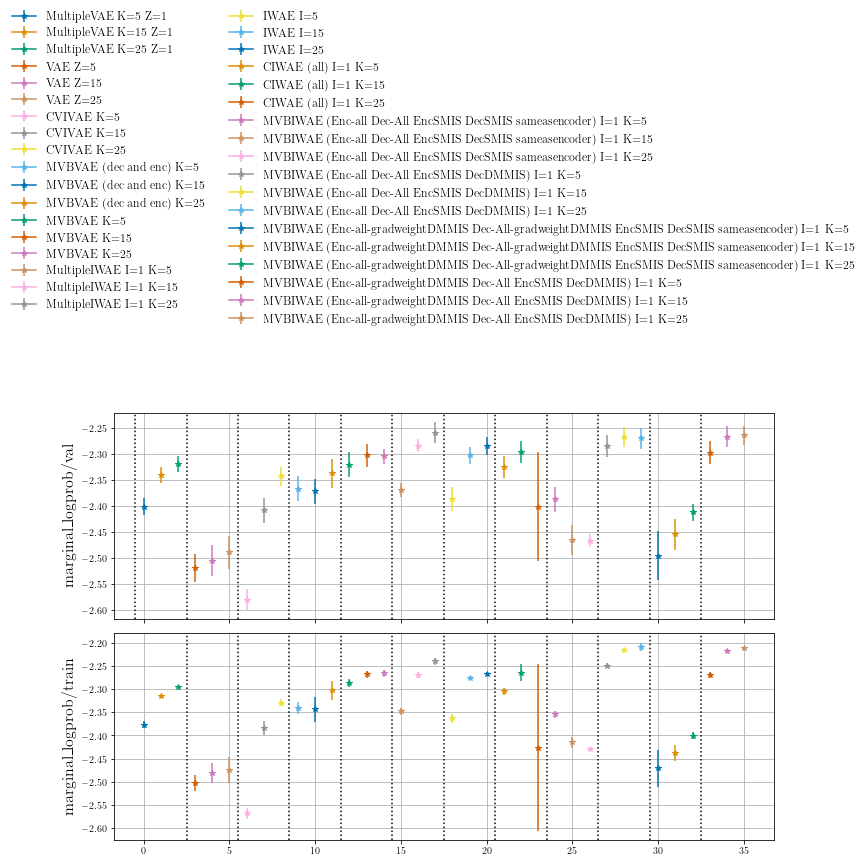

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

for i, (model, stats) in enumerate(model_stats.items()):
    metric0 = metrics[2]
    axes[0].errorbar(i, np.mean(stats[metric0]), 
                     yerr=np.std(stats[metric0], ddof=1)/np.sqrt(len(stats[metric0])), 
                     label=model,
                     color=colors[i],
                     marker='*')
    metric1 = metrics[3]
    axes[1].errorbar(i, np.mean(stats[metric1]), 
                     yerr=np.std(stats[metric1], ddof=1)/np.sqrt(len(stats[metric1])), 
                     label=model,
                     color=colors[i],
                     marker='*')

axes[0].grid()
axes[0].set_ylabel(metric0, fontsize=16)
axes[1].grid()
axes[1].set_ylabel(metric1, fontsize=16)
                                                                                 
groups = [3,3,3,3,3,3,3,3,3,3,3]
vline_x = -0.5
axes[0].axvline(x=vline_x, color='k', linestyle=":")
for g in groups:
    vline_x += g
    axes[0].axvline(x=vline_x, color='k', linestyle=":")
    axes[1].axvline(x=vline_x, color='k', linestyle=":")
    


handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels,
          ncol=2, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
          frameon=False, fontsize=12)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.96))

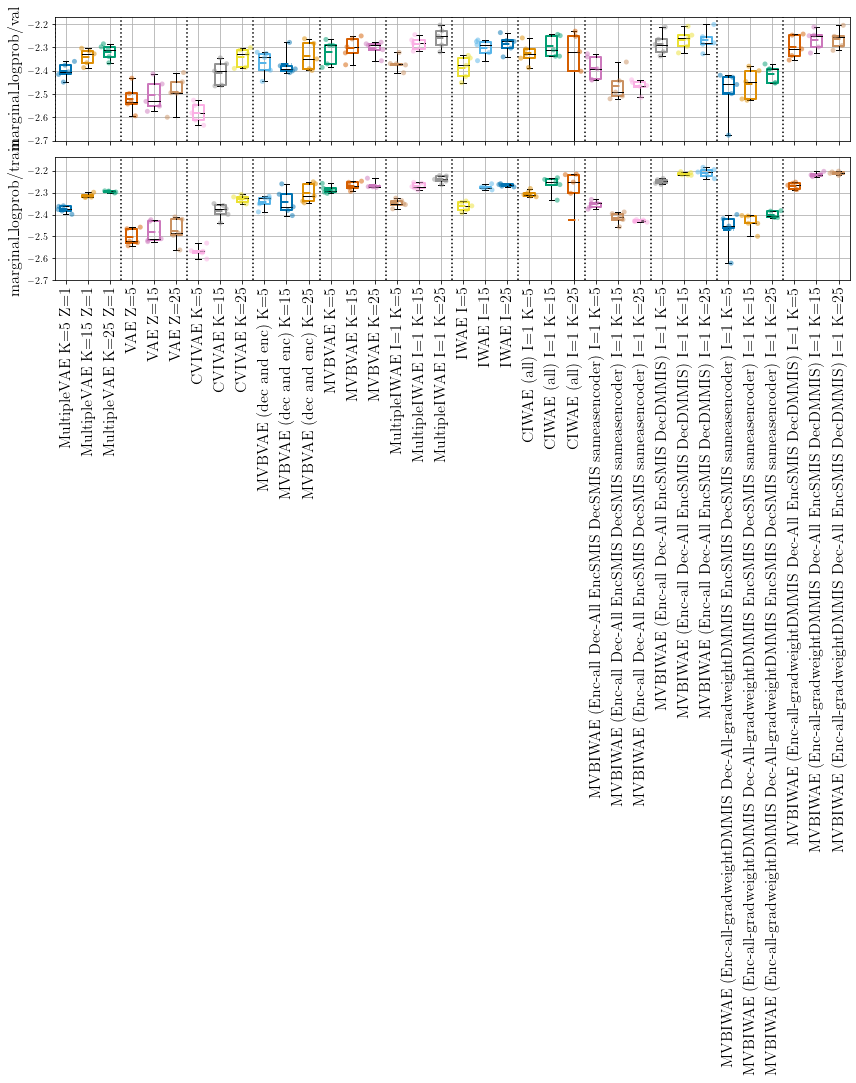

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12,15), sharex=False, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

metric_box_data = defaultdict(list)
model_labels = []
for i, (model, stats) in enumerate(model_stats.items()):
    model_labels.append(model)

    metric0 = metrics[2]
    metric_box_data[metric0].append(stats[metric0])
    
    metric1 = metrics[3]
    metric_box_data[metric1].append(stats[metric1])

plot_cust_boxplot(axes[0], metric_box_data[metric0], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
plot_custom_stripplot(axes[0], metric_box_data[metric0], model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.5})

plot_cust_boxplot(axes[1], metric_box_data[metric1], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
plot_custom_stripplot(axes[1], metric_box_data[metric1], model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.5})
    
axes[0].grid()
axes[0].set_ylabel(metric0, fontsize=16)
axes[1].grid()
axes[1].set_ylabel(metric1, fontsize=16)

axes[0].set_xticks(np.arange(0, len(metric_box_data[metric0])), labels=[])
axes[-1].set_xticks(np.arange(0, len(metric_box_data[metric0])), labels=model_labels, fontsize=16)
plt.setp(axes[-1].get_xticklabels(), rotation=90, ha='center')

groups = [3,3,3,3,3,3,3,3,3,3,3]
vline_x = -0.5
axes[0].axvline(x=vline_x, color='k', linestyle=":")
for g in groups:
    vline_x += g
    axes[0].axvline(x=vline_x, color='k', linestyle=":")
    axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[0].set_ylim(-2.7, None)
axes[1].set_ylim(-2.7, None)
    
# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles, labels,
#           ncol=4, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
#           frameon=False, fontsize=12)

fig.tight_layout()

### Paper figure

In [17]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/compare/{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models_vae = [
    # VAE
    {
        'name': 'vae_z5_encm_stl_mlp',
        'label_name': 'MVAE Z=5'
    },
    {
        'name': 'vae_z15_encm_stl_mlp',
        'label_name': 'MVAE Z=15'
    },
    {
        'name': 'vae_z25_encm_stl_mlp',
        'label_name': 'MVAE Z=25'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_varnormeps_k5_z1_encm_stl_mlp',
        'label_name': 'MissVAE K=5 Z=5'
    },
    {
        'name': 'reparametrisedmixture_vae_varnormeps_k15_z1_encm_stl_mlp',
        'label_name': 'MissVAE K=15 Z=15'
    },
    {
        'name': 'reparametrisedmixture_vae_varnormeps_k25_z1_encm_stl_mlp',
        'label_name': 'MissVAE K=25 Z=25'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl_mlp',
        'label_name': 'MissSVAE K=5 Z=1'
    },
    {
        'name': 'multiple_vae_k15_z1_encm_stl_mlp',
        'label_name': 'MissSVAE K=15 Z=1'
    },
    {
        'name': 'multiple_vae_k25_z1_encm_stl_mlp',
        'label_name': 'MissSVAE K=25 Z=1'
    },
#     # MultipleVAE2
#     {
#         'name': 'multiple2_vae_k5_z1_encm_stl_mlp',
#         'label_name': 'Miss(S)VAE K=5 Z=1'
#     },
#     {
#         'name': 'multiple2_vae_k15_z1_encm_stl_mlp',
#         'label_name': 'Miss(S)VAE K=15 Z=1'
#     },
#     {
#         'name': 'multiple2_vae_k25_z1_encm_stl_mlp',
#         'label_name': 'Miss(S)VAE K=25 Z=1'
#     },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl_mlp',
        'label_name': 'MIWAE I=5'
    },
    {
        'name': 'iwae_i15_encm_stl_mlp',
        'label_name': 'MIWAE I=15'
    },
    {
        'name': 'iwae_i25_encm_stl_mlp',
        'label_name': 'MIWAE I=25'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_varnormeps_k5_i1_encm_stl_mlp',
        'label_name': 'MissIWAE K=5 I=5'
    },
    {
        'name': 'reparametrisedmixture_iwae_varnormeps_k15_i1_encm_stl_mlp',
        'label_name': 'MissIWAE K=15 I=15'
    },
    {
        'name': 'reparametrisedmixture_iwae_varnormeps_k25_i1_encm_stl_mlp',
        'label_name': 'MissIWAE K=25 I=25'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl_mlp',
        'label_name': 'MissSIWAE K=5 I=1'
    },
    {
        'name': 'multiple_iwae_k15_i1_encm_stl_mlp',
        'label_name': 'MissSIWAE K=15 I=1'
    },
    {
        'name': 'multiple_iwae_k25_i1_encm_stl_mlp',
        'label_name': 'MissSIWAE K=25 I=1'
    },
#     # MultipleIWAE2
#     {
#         'name': 'multiple2_iwae_k5_i1_encm_stl_mlp',
#         'label_name': 'Miss(S)IWAE K=5 I=1'
#     },
#     {
#         'name': 'multiple2_iwae_k15_i1_encm_stl_mlp',
#         'label_name': 'Miss(S)IWAE K=15 I=1'
#     },
#     {
#         'name': 'multiple2_iwae_k25_i1_encm_stl_mlp',
#         'label_name': 'Miss(S)IWAE K=25 I=1'
#     },
#     # CVIVAE
#     {
#         'name': 'cvivae_lairdmisr0_k5_stl_mlp',
#         'label_name': 'CVI-VAE K=5'
#     },
#     {
#         'name': 'cvivae_lairdmisr0_k15_stl_mlp',
#         'label_name': 'CVI-VAE K=15'
#     },
#     {
#         'name': 'cvivae_lairdmisr0_k25_stl_mlp',
#         'label_name': 'CVI-VAE K=25'
#     },
#     # MVB-VAE (both decoder and encoder)
#     {
#         'name': 'mvbvae_lairdmisr0_k5_stl_mlp',
# #         'label_name': 'MVBVAE (dec and enc) K=5'
#         'label_name': 'MVB-VAE K=5'
#     },
#     {
#         'name': 'mvbvae_lairdmisr0_k15_stl_mlp',
# #         'label_name': 'MVBVAE (dec and enc) K=15'
#         'label_name': 'MVB-VAE K=15'
#     },
#     {
#         'name': 'mvbvae_lairdmisr0_k25_stl_mlp',
# #         'label_name': 'MVBVAE (dec and enc) K=25'
#         'label_name': 'MVB-VAE K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_lairdmisr0_k5_stl_mlp',
#         'label_name': 'MVBVAE K=5'
        'label_name': 'DeMissVAE K=5'
    },
    {
        'name': 'mvb2vae_lairdmisr0_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
        'label_name': 'DeMissVAE K=15'
    },
    {
        'name': 'mvb2vae_lairdmisr0_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
        'label_name': 'DeMissVAE K=25'
    },
]


metrics = ['complete_marginal_logprob/train',
           'complete_marginal_logprob/val',
           'marginal_logprob/val',
           'marginal_logprob/train']

vae_model_stats = defaultdict(lambda: defaultdict(list))
for model in tqdm(models_vae):
    for seed in seeds:
        log_dir = log_dir_template.format(model['name'], seed)

        stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
        for m in metrics:
            vae_model_stats[model['label_name']][m].append(np.nanmax(stats[m]))


100%|██████████████████████████████████████████████████████████| 21/21 [14:24<00:00, 41.19s/it]


In [18]:
baselines = ['MVAE', 'MIWAE']

/home/vaidas/Projects/vgiwae/vgiwae/utils/plotting.py:65: UserWarning: The palette list has more values (30) than needed (21), which may not be intended.
  sns.stripplot(


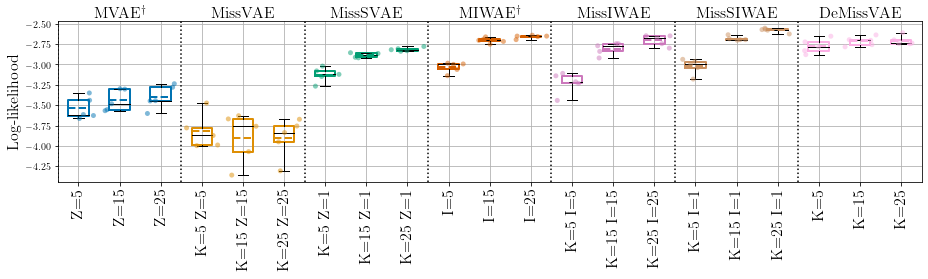

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(13,4), sharex=False, sharey=True)

colors = sns.color_palette(palette='colorblind', n_colors=10)
num_experiments_for_each_model = 3
colors = [c for c in colors for i in range(num_experiments_for_each_model)]

metric0 = 'complete_marginal_logprob/val'

# VAEs

metric_box_data = defaultdict(list)
model_labels = []
for i, (model, stats) in enumerate(vae_model_stats.items()):
    model_labels.append(model)

    metric_box_data[metric0].append(stats[metric0])

plot_cust_boxplot(axes, metric_box_data[metric0], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
plot_custom_stripplot(axes, metric_box_data[metric0], model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.5})

# Clean out labels
for i, model_label in enumerate(model_labels[::num_experiments_for_each_model]):
    num_labels = len(model_labels)/num_experiments_for_each_model
    model_label = re.split('Z=|K=|I=', model_label)[0]
    model_label = model_label[:-1]
    if model_label in baselines:
        model_label += '\\textsuperscript{$\\dagger$}'
    axes.text(0.5/num_labels + i*1/num_labels, 1.02, model_label, 
                 fontsize=16, ha='center', 
                 transform=axes.transAxes)

tick_labels = []
for model_label in model_labels:
    if 'VAE' in model_label:
        model_label = re.split('VAE ', model_label)[1] 
    elif 'IWAE' in model_label:
        model_label = re.split('IWAE ', model_label)[1]
    tick_labels.append(model_label)
    

axes.set_xticks(np.arange(0, len(metric_box_data[metric0])), labels=tick_labels, fontsize=16)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')



axes.grid()
axes.set_ylabel('Log-likelihood', fontsize=16)


groups = [3,3,3,3,3,3,]#3,3]
vline_x = -0.5
axes.axvline(x=vline_x, color='k', linestyle=":")
for g in groups:
    vline_x += g
    axes.axvline(x=vline_x, color='k', linestyle=":")
    
# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles, labels,
#           ncol=4, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
#           frameon=False, fontsize=12)

fig.tight_layout()

# fig.savefig('./figures/toymog2large_complete_test_loglikelihood.pdf')

### MVB-VAE vs CVI-VAE vs DeMissVAE

In [33]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/compare/{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models_vae = [
    # CVIVAE
    {
        'name': 'cvivae_lairdmisr0_k5_stl_mlp',
        'label_name': 'CVI-VAE K=5'
    },
    {
        'name': 'cvivae_lairdmisr0_k15_stl_mlp',
        'label_name': 'CVI-VAE K=15'
    },
    {
        'name': 'cvivae_lairdmisr0_k25_stl_mlp',
        'label_name': 'CVI-VAE K=25'
    },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_lairdmisr0_k5_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=5'
        'label_name': 'MVB-VAE K=5'
    },
    {
        'name': 'mvbvae_lairdmisr0_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
        'label_name': 'MVB-VAE K=15'
    },
    {
        'name': 'mvbvae_lairdmisr0_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
        'label_name': 'MVB-VAE K=25'
    },
    # MVB-VAE
    {
        'name': 'mvb2vae_lairdmisr0_k5_stl_mlp',
#         'label_name': 'MVBVAE K=5'
        'label_name': 'DeMissVAE K=5'
    },
    {
        'name': 'mvb2vae_lairdmisr0_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
        'label_name': 'DeMissVAE K=15'
    },
    {
        'name': 'mvb2vae_lairdmisr0_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
        'label_name': 'DeMissVAE K=25'
    },
]


metrics = ['complete_marginal_logprob/train',
           'complete_marginal_logprob/val',
           'marginal_logprob/val',
           'marginal_logprob/train']

control_model_stats = defaultdict(lambda: defaultdict(list))
for model in tqdm(models_vae):
    for seed in seeds:
        log_dir = log_dir_template.format(model['name'], seed)

        stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
        for m in metrics:
            control_model_stats[model['label_name']][m].append(np.nanmax(stats[m]))


100%|████████████████████████████████████████████████████████████| 9/9 [06:28<00:00, 43.15s/it]


/home/vaidas/Projects/vgiwae/vgiwae/utils/plotting.py:65: UserWarning: The palette list has more values (30) than needed (9), which may not be intended.
  sns.stripplot(


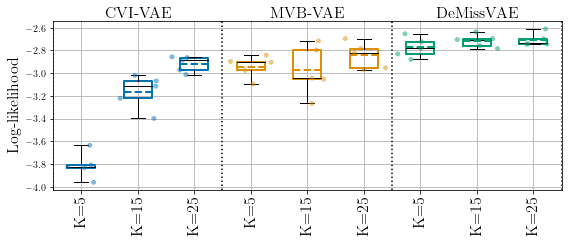

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(8,3.5), sharex=False, sharey=True)

colors = sns.color_palette(palette='colorblind', n_colors=10)
num_experiments_for_each_model = 3
colors = [c for c in colors for i in range(num_experiments_for_each_model)]

metric0 = 'complete_marginal_logprob/val'

# VAEs

metric_box_data = defaultdict(list)
model_labels = []
for i, (model, stats) in enumerate(control_model_stats.items()):
    model_labels.append(model)

    metric_box_data[metric0].append(stats[metric0])

plot_cust_boxplot(axes, metric_box_data[metric0], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
plot_custom_stripplot(axes, metric_box_data[metric0], model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.5})

# Clean out labels
for i, model_label in enumerate(model_labels[::num_experiments_for_each_model]):
    num_labels = len(model_labels)/num_experiments_for_each_model
    model_label = re.split('Z=|K=|I=', model_label)[0]
    axes.text(0.5/num_labels + i*1/num_labels, 1.02, model_label, 
                 fontsize=16, ha='center', 
                 transform=axes.transAxes)

tick_labels = []
for model_label in model_labels:
    if 'VAE' in model_label:
        model_label = re.split('VAE ', model_label)[1] 
    elif 'IWAE' in model_label:
        model_label = re.split('IWAE ', model_label)[1]
    tick_labels.append(model_label)
    

axes.set_xticks(np.arange(0, len(metric_box_data[metric0])), labels=tick_labels, fontsize=16)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')



axes.grid()
axes.set_ylabel('Log-likelihood', fontsize=16)


groups = [3,3,3]
vline_x = -0.5
axes.axvline(x=vline_x, color='k', linestyle=":")
for g in groups:
    vline_x += g
    axes.axvline(x=vline_x, color='k', linestyle=":")
    

fig.tight_layout()

# fig.savefig('./figures/toymog2large_complete_test_loglikelihood_demiss_control_study.pdf')

### Reg-VAE 

In [21]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/compare/{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
    # VAE
    {
        'name': 'vae_z5_encm_stl_mlp',
        'label_name': 'VAE Z=5'
    },
    {
        'name': 'vae_z15_encm_stl_mlp',
        'label_name': 'VAE Z=15'
    },
    {
        'name': 'vae_z25_encm_stl_mlp',
        'label_name': 'VAE Z=25'
    },
    # RegVAE
    {
        'name': 'reg_a01_p02_vae_z5_encm_stl_mlp',
        'label_name': 'RegVAE Z=5 a=0.1 p=0.2'
    },
    {
        'name': 'reg_a01_p02_vae_z15_encm_stl_mlp',
        'label_name': 'RegVAE Z=15 a=0.1 p=0.2'
    },
    {
        'name': 'reg_a01_p02_vae_z25_encm_stl_mlp',
        'label_name': 'RegVAE Z=25 a=0.1 p=0.2'
    },
    # RegVAE
    {
        'name': 'reg_a05_p04_vae_z5_encm_stl_mlp',
        'label_name': 'RegVAE Z=5 a=0.5 p=0.4'
    },
    {
        'name': 'reg_a05_p04_vae_z15_encm_stl_mlp',
        'label_name': 'RegVAE Z=15 a=0.5 p=0.4'
    },
    {
        'name': 'reg_a05_p04_vae_z25_encm_stl_mlp',
        'label_name': 'RegVAE Z=25 a=0.5 p=0.4'
    },
    # IWAE
    {
        'name': 'iwae_i5_encm_stl_mlp',
        'label_name': 'IWAE I=5'
    },
    {
        'name': 'iwae_i15_encm_stl_mlp',
        'label_name': 'IWAE I=15'
    },
    {
        'name': 'iwae_i25_encm_stl_mlp',
        'label_name': 'IWAE I=25'
    },
    # RegIWAE
    {
        'name': 'reg_a01_p02_iwae_i5_encm_stl_mlp',
        'label_name': 'RegIWAE I=5 a=0.1 p=0.2'
    },
    {
        'name': 'reg_a01_p02_iwae_i15_encm_stl_mlp',
        'label_name': 'RegIWAE I=15 a=0.1 p=0.2'
    },
    {
        'name': 'reg_a01_p02_iwae_i25_encm_stl_mlp',
        'label_name': 'RegIWAE I=25 a=0.1 p=0.2'
    },
    # RegIWAE
    {
        'name': 'reg_a05_p04_iwae_i5_encm_stl_mlp',
        'label_name': 'RegIWAE I=5 a=0.5 p=0.4'
    },
    {
        'name': 'reg_a05_p04_iwae_i15_encm_stl_mlp',
        'label_name': 'RegIWAE I=15 a=0.5 p=0.4'
    },
    {
        'name': 'reg_a05_p04_iwae_i25_encm_stl_mlp',
        'label_name': 'RegIWAE I=25 a=0.5 p=0.4'
    },
]

metrics = ['complete_marginal_logprob/train',
           'complete_marginal_logprob/val',
           'marginal_logprob/val',
           'marginal_logprob/train']

reg_model_stats = defaultdict(lambda: defaultdict(list))
for model in tqdm(models):
    for seed in seeds:
        log_dir = log_dir_template.format(model['name'], seed)

        stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
        for m in metrics:
            reg_model_stats[model['label_name']][m].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 18/18 [14:48<00:00, 49.34s/it]


/home/vaidas/Projects/vgiwae/vgiwae/utils/plotting.py:65: UserWarning: The palette list has more values (30) than needed (18), which may not be intended.
  sns.stripplot(


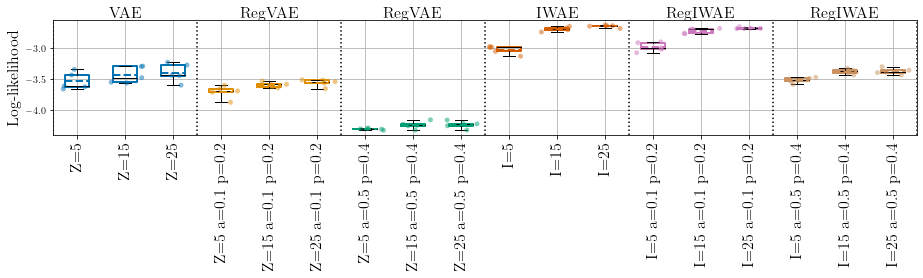

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(13,4), sharex=False, sharey=True)

colors = sns.color_palette(palette='colorblind', n_colors=10)
num_experiments_for_each_model = 3
colors = [c for c in colors for i in range(num_experiments_for_each_model)]

metric0 = 'complete_marginal_logprob/val'

# VAEs

metric_box_data = defaultdict(list)
model_labels = []
for i, (model, stats) in enumerate(reg_model_stats.items()):
    model_labels.append(model)

    metric_box_data[metric0].append(stats[metric0])

plot_cust_boxplot(axes, metric_box_data[metric0], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
plot_custom_stripplot(axes, metric_box_data[metric0], model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.5})

# Clean out labels
for i, model_label in enumerate(model_labels[::num_experiments_for_each_model]):
    num_labels = len(model_labels)/num_experiments_for_each_model
    model_label = re.split('Z=|K=|I=', model_label)[0]
    model_label = model_label[:-1]
    if model_label in baselines:
        model_label += '\\textsuperscript{$\\dagger$}'
    axes.text(0.5/num_labels + i*1/num_labels, 1.02, model_label, 
                 fontsize=16, ha='center', 
                 transform=axes.transAxes)

tick_labels = []
for model_label in model_labels:
    if 'VAE' in model_label:
        model_label = re.split('VAE ', model_label)[1] 
    elif 'IWAE' in model_label:
        model_label = re.split('IWAE ', model_label)[1]
    tick_labels.append(model_label)
    

axes.set_xticks(np.arange(0, len(metric_box_data[metric0])), labels=tick_labels, fontsize=16)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')



axes.grid()
axes.set_ylabel('Log-likelihood', fontsize=16)


groups = [3,3,3,3,3,3]#3,3]
vline_x = -0.5
axes.axvline(x=vline_x, color='k', linestyle=":")
for g in groups:
    vline_x += g
    axes.axvline(x=vline_x, color='k', linestyle=":")
    
# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles, labels,
#           ncol=4, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
#           frameon=False, fontsize=12)

fig.tight_layout()


## Oracle control studies (and annealing away from the oracle imputation distribution)

### Linear interpolate to independent marginal MoGs to independent marginal Gaussian

In [202]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'

seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_{{}}/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
oracle_interpolation_labels = ['050', '075', '090', '098', '100']
interp_target = 'indepmargmog_to_indepmarggauss'

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp_target, interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp_target + '_'+ interp][key].append(stats[key])
            
# oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_{{}}/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
oracle_interpolation_labels = ['000', '025', '050', '075', '100']
interp_target = 'indepmargmog'

for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp_target, interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp_target + '_' + interp][key].append(stats[key])

In [203]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'indepmargmog_to_indepmarggauss_050': defaultdict(list,
                         {'kldiv_fow': [array(234.05496, dtype=float32)],
                          'kldiv_rev': [array(6.059337, dtype=float32)],
                          'jsd': [array(0.6190505, dtype=float32)]}),
             'indepmargmog_to_indepmarggauss_075': defaultdict(list,
                         {'kldiv_fow': [array(118.65432, dtype=float32)],
                          'kldiv_rev': [array(5.238059, dtype=float32)],
                          'jsd': [array(0.5983828, dtype=float32)]}),
             'indepmargmog_to_indepmarggauss_090': defaultdict(list,
                         {'kldiv_fow': [array(50.739628, dtype=float32)],
                          'kldiv_rev': [array(4.2199745, dtype=float32)],
                          'jsd': [array(0.55938, dtype=float32)]}),
             'indepmargmog_to_indepmarggauss_098': defaultdict(list,
                         {'kld

In [204]:
data = 'toy_mog2_large'
group = 'mis50'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_{{}}/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

oracle_interpolation_labels = ['050', '075', '090', '098', ]#'100']
interp_target = 'indepmargmog_to_indepmarggauss'
model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(interp_target, model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp_target + '_' + interp][-1]
                    model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp_target + '_' + interp].append(np.nanmax(stats[m]))

                
oracle_interpolation_labels = ['000', '025', '050', '075', '100']
interp_target = 'indepmargmog'

for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(interp_target, model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp_target + '_' + interp][-1]
                    model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp_target + '_' + interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:22<00:00, 127.44s/it]


#### Test

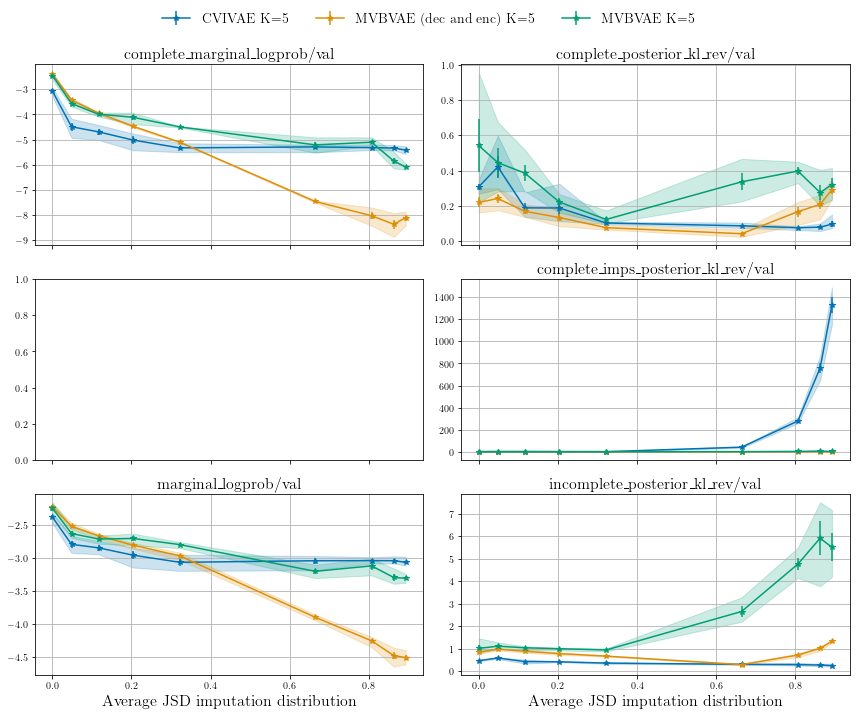

In [205]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

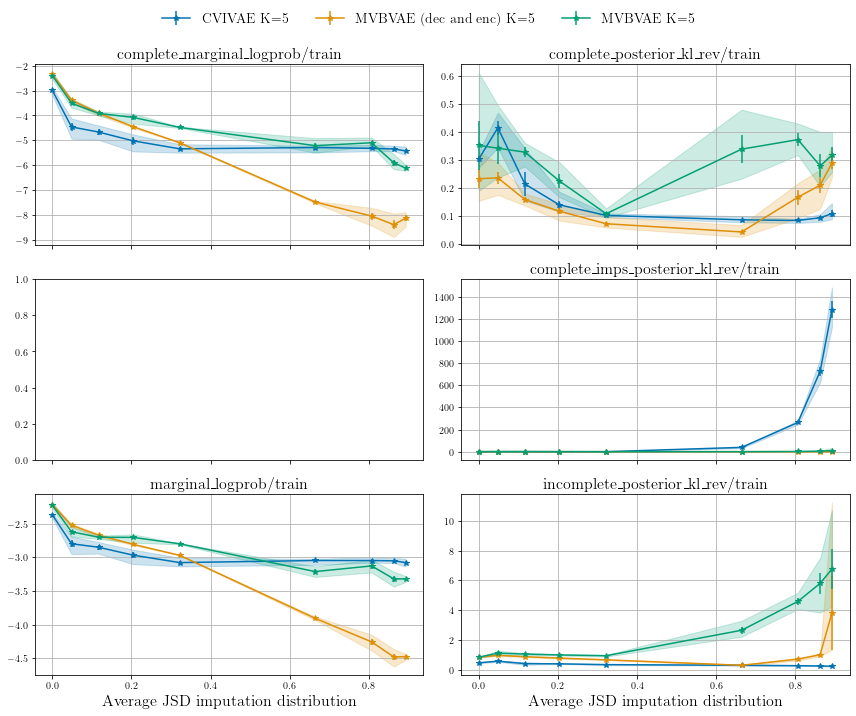

In [206]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond MoGs with mode collapse to max-prob mode

In [207]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_maxprob_mode/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'

seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [208]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(0.24655314, dtype=float32)],
                          'kldiv_rev': [array(28.48643, dtype=float32)],
                          'jsd': [array(0.07592094, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(0.11343449, dtype=float32)],
                          'kldiv_rev': [array(0.14540355, dtype=float32)],
                          'jsd': [array(0.03045356, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(0.04732757, dtype=float32)],
                          'kldiv_rev': [array(0.05094836, dtype=float32)],
                          'jsd': [array(0.01206416, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(0.01159805, dtype=float32)],
                          'kldiv_rev': [array(0.01163372, dtype=floa

In [209]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_maxprob_mode/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:20<00:00, 127.00s/it]


#### Test

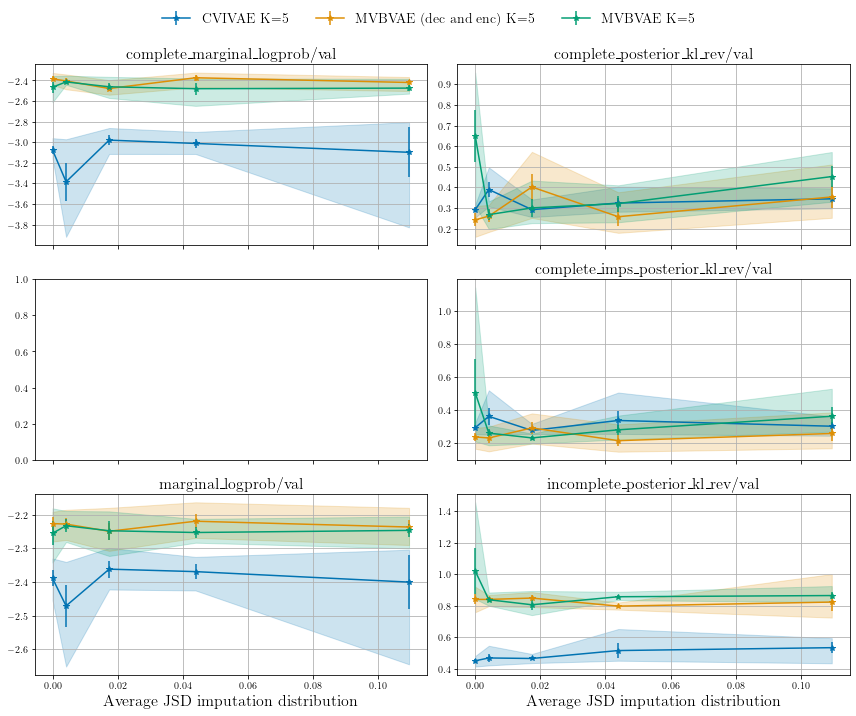

In [210]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

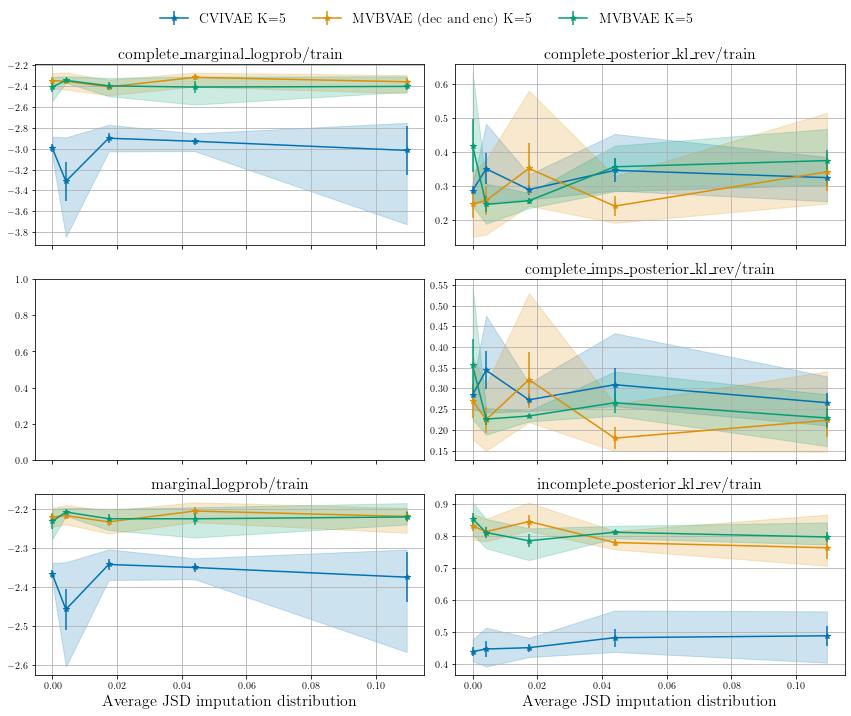

In [211]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond MoGs with mode collapse to second-max-prob mode

In [212]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_secondlargestprob_mode/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [213]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(7.1253524, dtype=float32)],
                          'kldiv_rev': [array(122.31163, dtype=float32)],
                          'jsd': [array(0.5229048, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(4.905492, dtype=float32)],
                          'kldiv_rev': [array(1.0409302, dtype=float32)],
                          'jsd': [array(0.268497, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(3.039534, dtype=float32)],
                          'kldiv_rev': [array(0.48137477, dtype=float32)],
                          'jsd': [array(0.1406744, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(1.3790251, dtype=float32)],
                          'kldiv_rev': [array(0.17506772, dtype=float32)],
   

In [214]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_secondlargestprob_mode/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:23<00:00, 127.79s/it]


#### Test

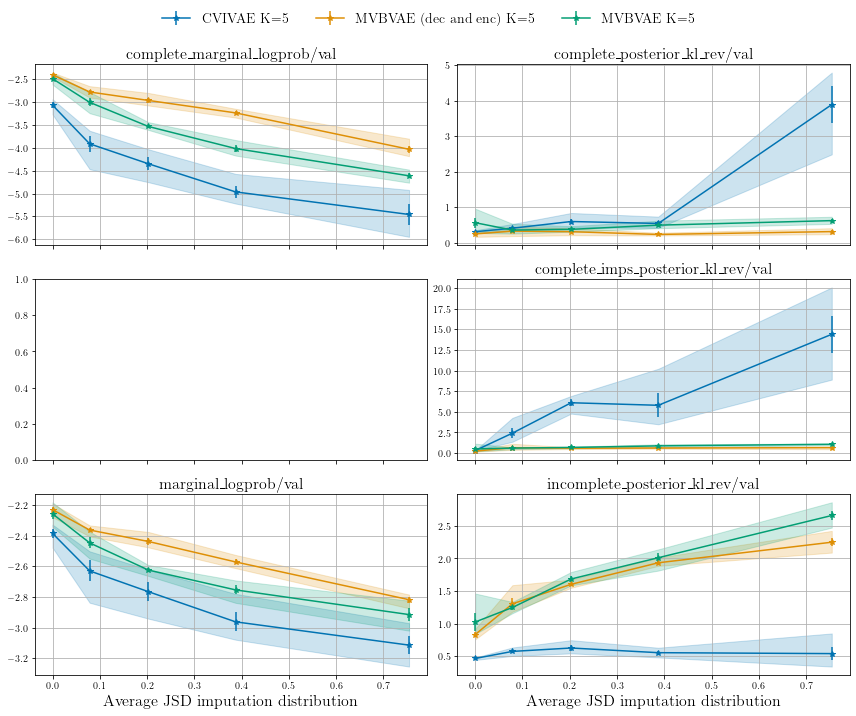

In [215]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

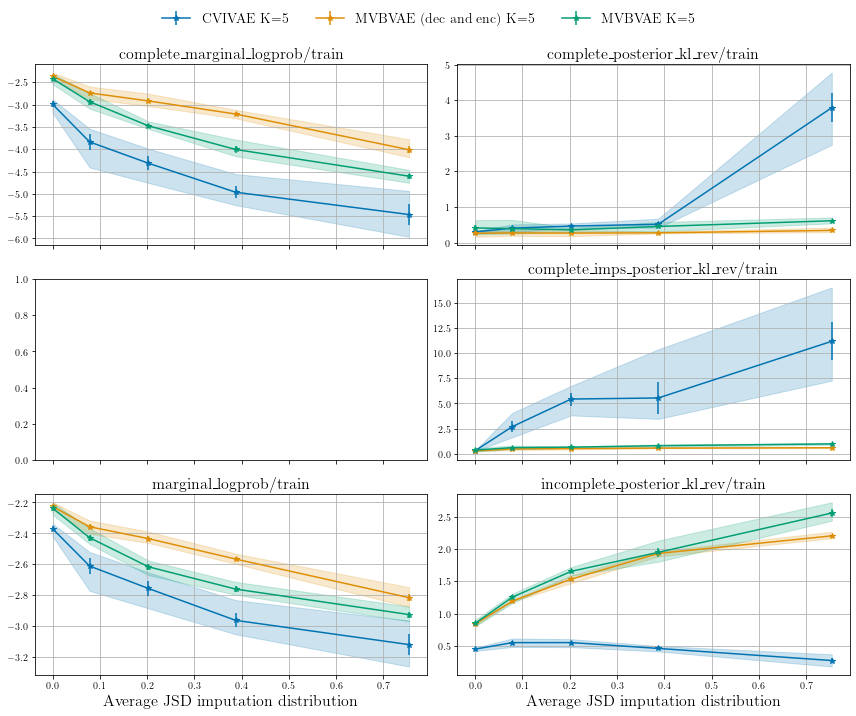

In [216]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond MoGs with mode collapse to third-max-prob mode

In [217]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_thirdlargestprob_mode/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [218]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(10.936337, dtype=float32)],
                          'kldiv_rev': [array(146.07576, dtype=float32)],
                          'jsd': [array(0.5880594, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(7.7171226, dtype=float32)],
                          'kldiv_rev': [array(1.1745905, dtype=float32)],
                          'jsd': [array(0.31111678, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(4.8797746, dtype=float32)],
                          'kldiv_rev': [array(0.56188786, dtype=float32)],
                          'jsd': [array(0.16828531, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(2.272047, dtype=float32)],
                          'kldiv_rev': [array(0.21495804, dtype=float32)],

In [219]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_thirdlargestprob_mode/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:28<00:00, 129.66s/it]


#### Test

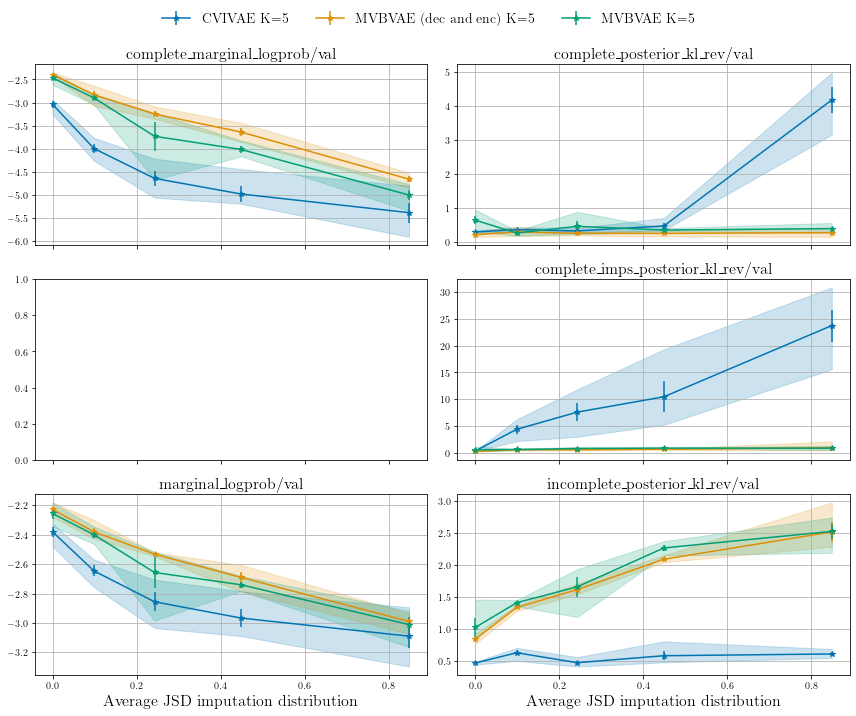

In [220]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

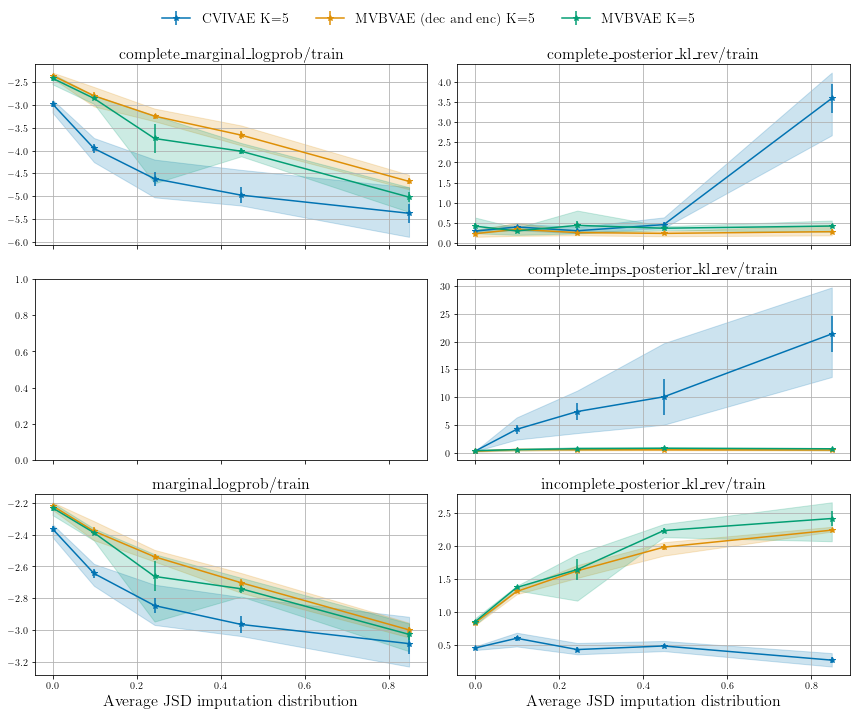

In [221]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond MoGs with mode collapse to fourth-max-prob mode

In [222]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_fourthlargestprob_mode/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [223]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(13.712923, dtype=float32)],
                          'kldiv_rev': [array(142.44348, dtype=float32)],
                          'jsd': [array(0.61650103, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(9.780491, dtype=float32)],
                          'kldiv_rev': [array(1.2327812, dtype=float32)],
                          'jsd': [array(0.33068058, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(6.2402444, dtype=float32)],
                          'kldiv_rev': [array(0.59917235, dtype=float32)],
                          'jsd': [array(0.18172279, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(2.9394743, dtype=float32)],
                          'kldiv_rev': [array(0.23517963, dtype=float32)]

In [224]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_fourthlargestprob_mode/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [07:44<00:00, 154.98s/it]


#### Test

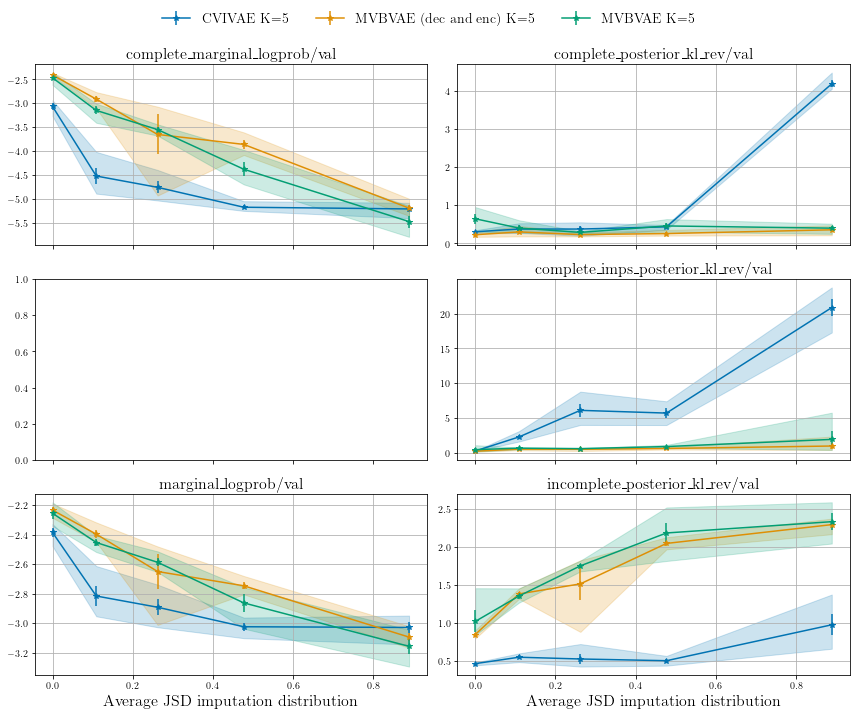

In [225]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

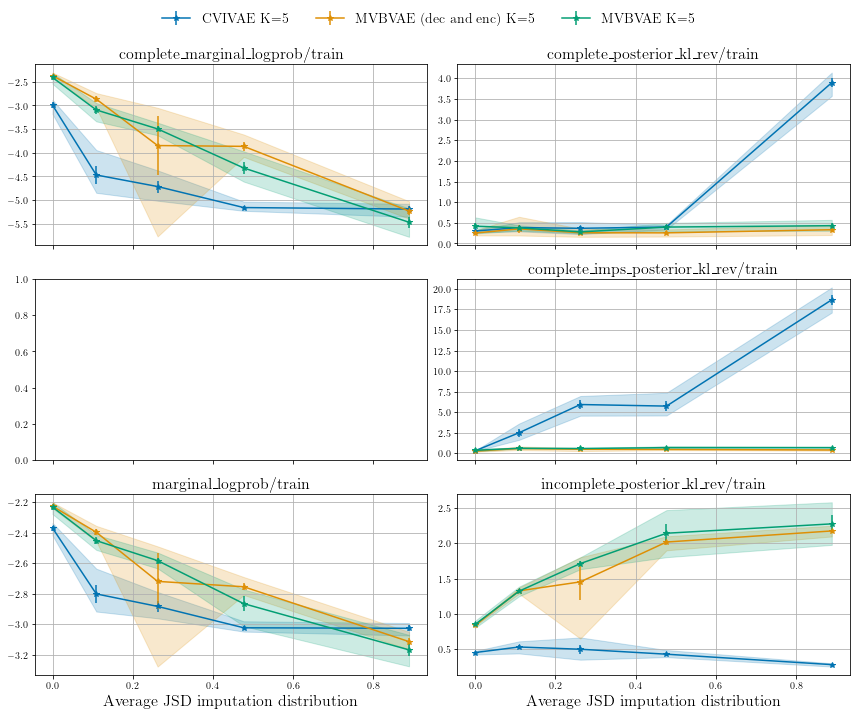

In [226]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond MoGs with mode collapse to fifth-max-prob mode

In [227]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_fifthlargestprob_mode/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [228]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(16.857918, dtype=float32)],
                          'kldiv_rev': [array(154.6596, dtype=float32)],
                          'jsd': [array(0.62234175, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(12.1355095, dtype=float32)],
                          'kldiv_rev': [array(1.2455554, dtype=float32)],
                          'jsd': [array(0.3365022, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(7.805037, dtype=float32)],
                          'kldiv_rev': [array(0.6107991, dtype=float32)],
                          'jsd': [array(0.18660833, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(3.716194, dtype=float32)],
                          'kldiv_rev': [array(0.24345767, dtype=float32)],
 

In [229]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_mode_collapse_to_fifthlargestprob_mode/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [07:14<00:00, 144.73s/it]


#### Test

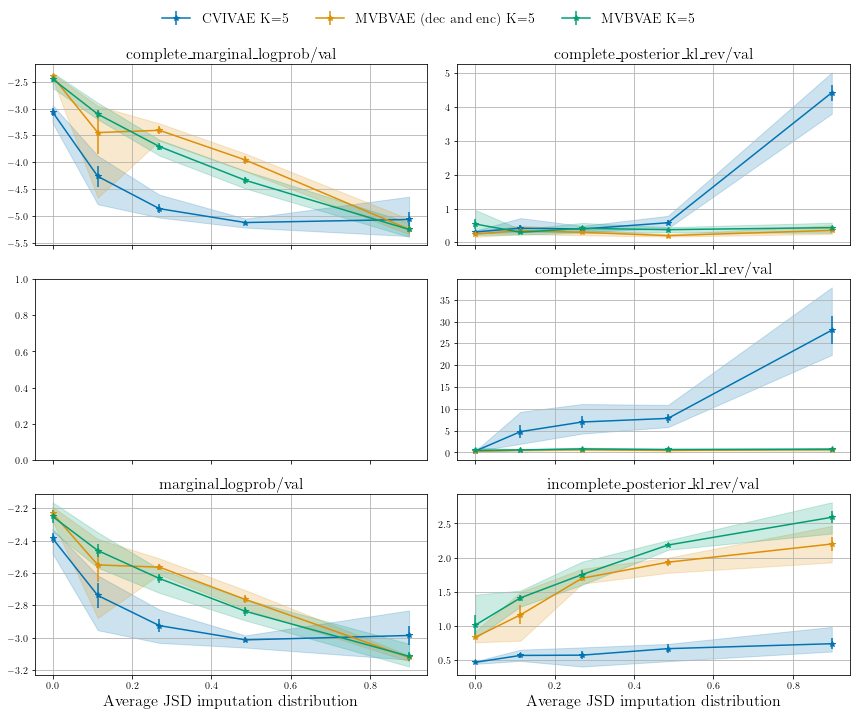

In [230]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

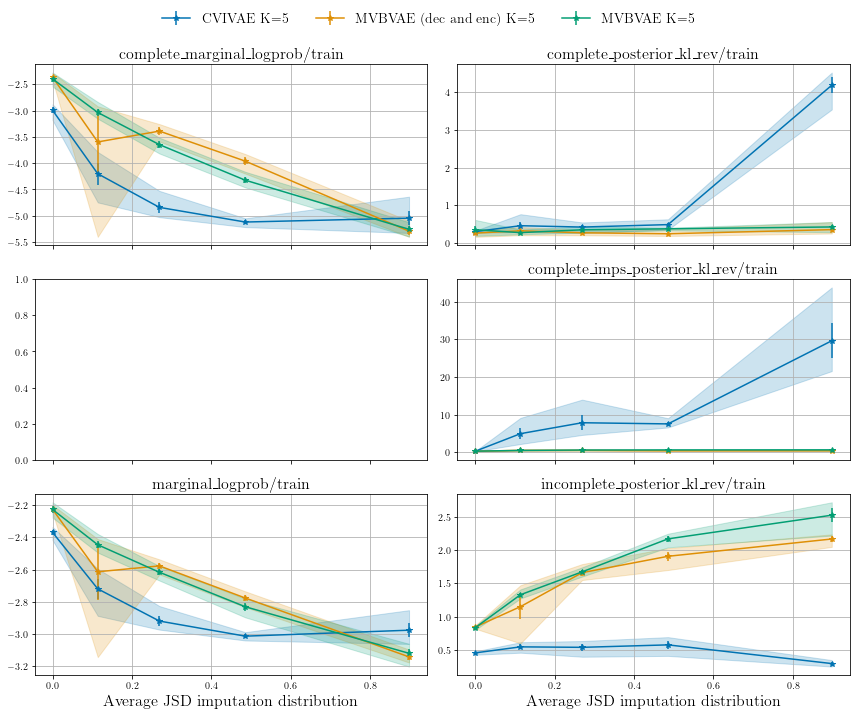

In [231]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond MoGs with equal component probabilities

In [232]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_equal_component_probabilities/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [233]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(16.520475, dtype=float32)],
                          'kldiv_rev': [array(1.7162448, dtype=float32)],
                          'jsd': [array(0.39943063, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(12.098476, dtype=float32)],
                          'kldiv_rev': [array(0.857626, dtype=float32)],
                          'jsd': [array(0.24671683, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(7.8633423, dtype=float32)],
                          'kldiv_rev': [array(0.45494458, dtype=float32)],
                          'jsd': [array(0.14239222, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(3.7890928, dtype=float32)],
                          'kldiv_rev': [array(0.18935534, dtype=float32)]

In [234]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_equal_component_probabilities/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:21<00:00, 127.31s/it]


#### Test

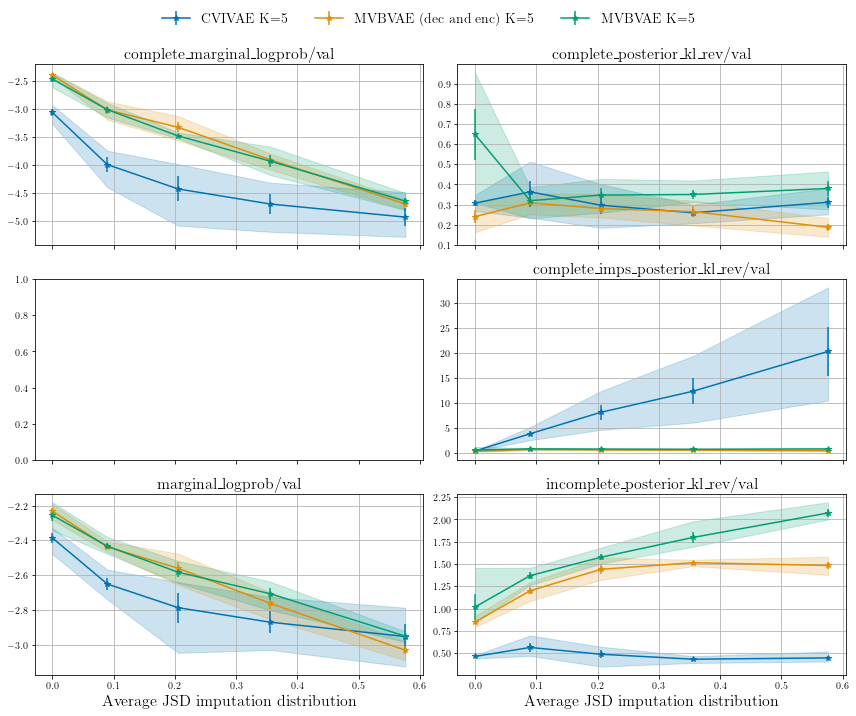

In [235]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

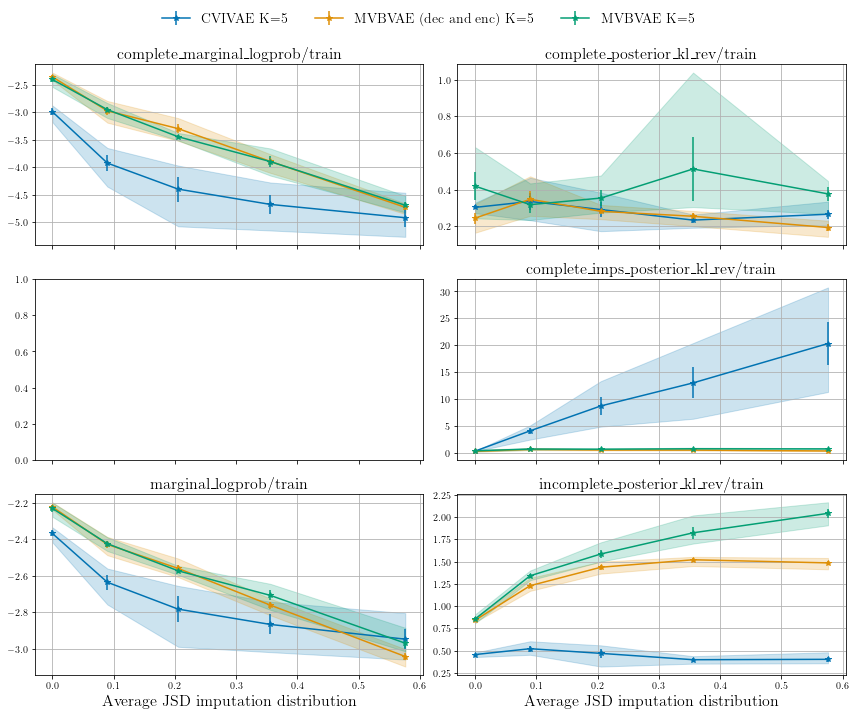

In [236]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond indep MoGs with reduced variance to 0.01var

In [185]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_indep_mog_with_var_shrinkage_to_001var/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [186]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(4.044096, dtype=float32)],
                          'kldiv_rev': [array(108.238655, dtype=float32)],
                          'jsd': [array(0.58102334, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(0.71503496, dtype=float32)],
                          'kldiv_rev': [array(1.7441686, dtype=float32)],
                          'jsd': [array(0.18580687, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(0.22032213, dtype=float32)],
                          'kldiv_rev': [array(0.34472406, dtype=float32)],
                          'jsd': [array(0.06021162, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(0.04323365, dtype=float32)],
                          'kldiv_rev': [array(0.05204613, dtype=float

In [190]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_indep_mog_with_var_shrinkage_to_001var/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:24<00:00, 128.03s/it]


#### Test

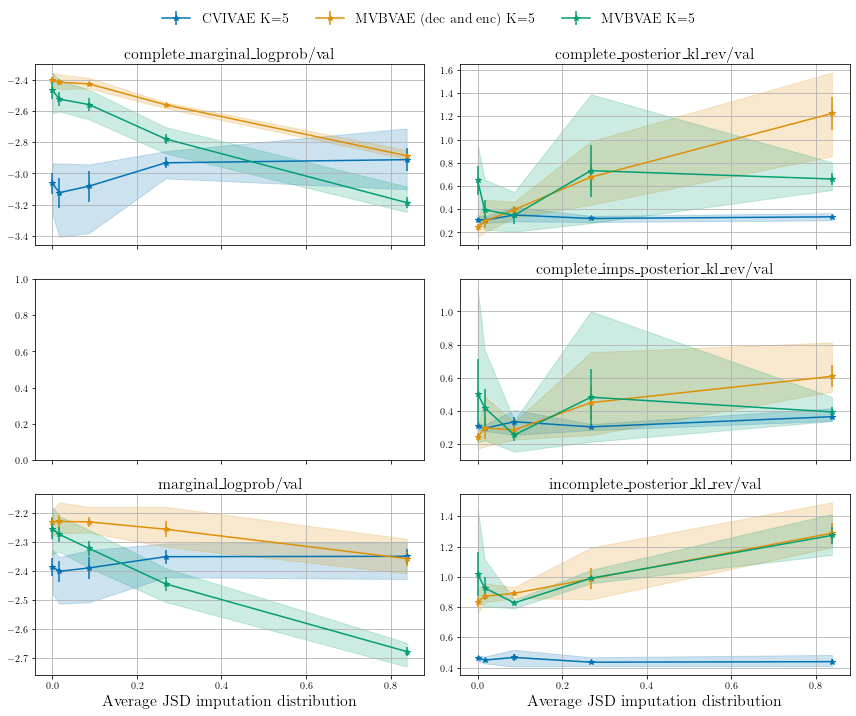

In [198]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

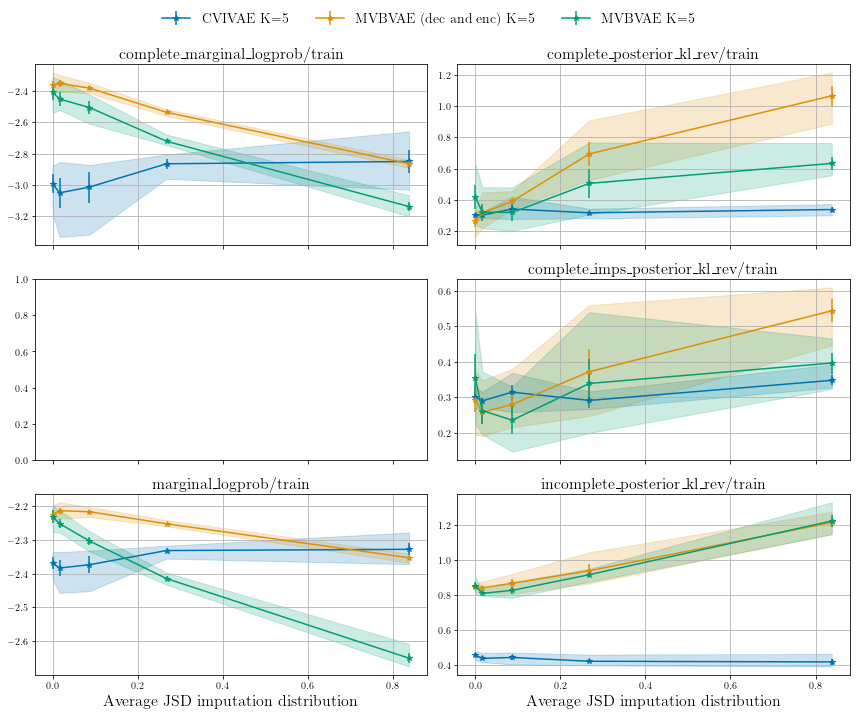

In [201]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond indep MoGs

In [247]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_indep_mog/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [248]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(0.98016113, dtype=float32)],
                          'kldiv_rev': [array(0.33287907, dtype=float32)],
                          'jsd': [array(0.07430641, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(0.7086017, dtype=float32)],
                          'kldiv_rev': [array(0.22955617, dtype=float32)],
                          'jsd': [array(0.05635826, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(0.44356835, dtype=float32)],
                          'kldiv_rev': [array(0.14888717, dtype=float32)],
                          'jsd': [array(0.0385401, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(0.1880627, dtype=float32)],
                          'kldiv_rev': [array(0.07289246, dtype=float

In [249]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_indep_mog/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:24<00:00, 128.15s/it]


#### Test

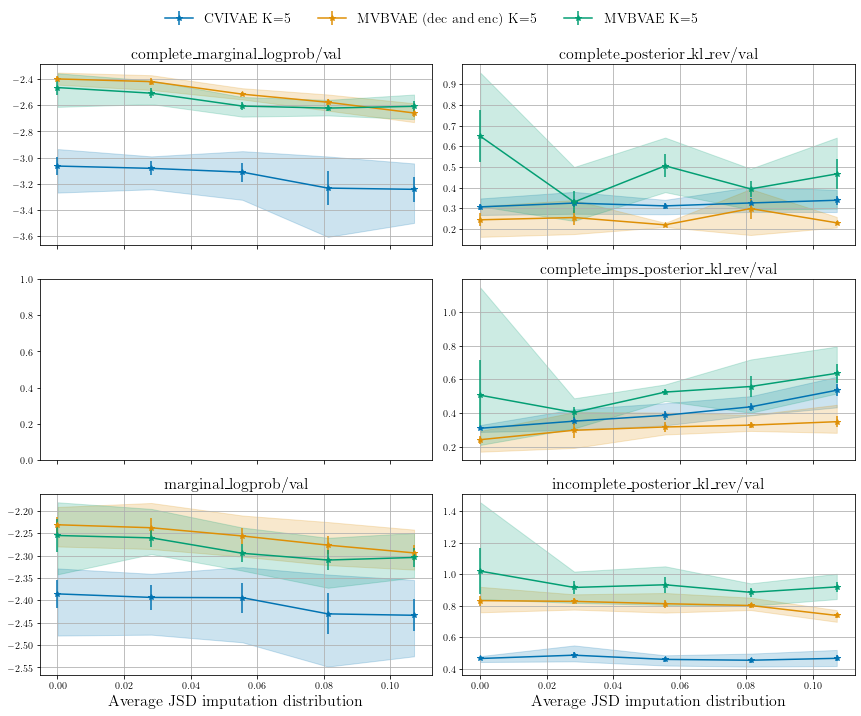

In [250]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

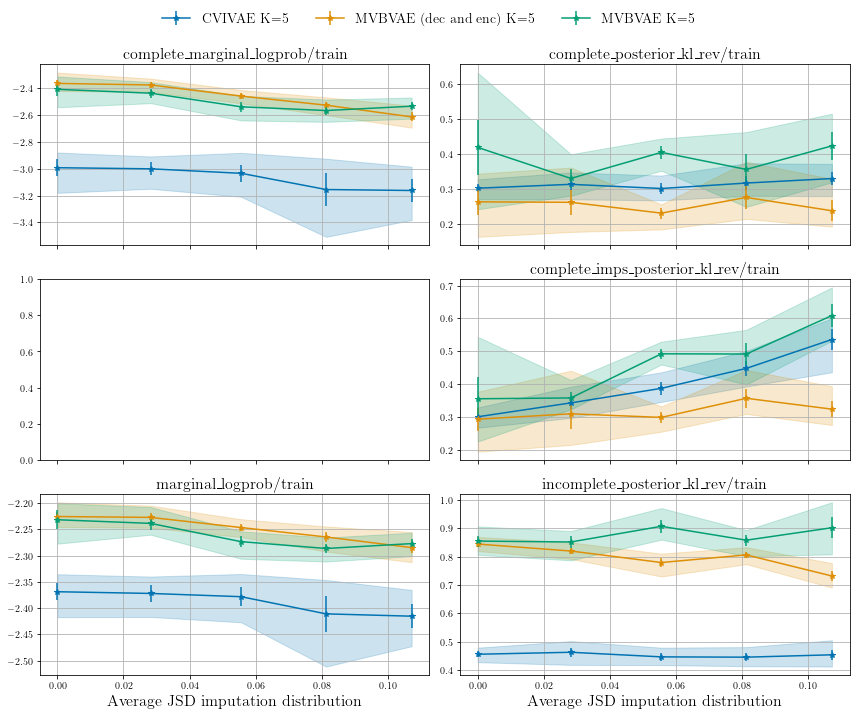

In [251]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

### Linear interpolate to cond indep MoGs created from indep true MoG

In [252]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_indep_mog_created_from_true_indep_mog/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            oracle_divs[interp][key].append(stats[key])

In [253]:
oracle_divs

defaultdict(<function __main__.<lambda>()>,
            {'000': defaultdict(list,
                         {'kldiv_fow': [array(9.694038, dtype=float32)],
                          'kldiv_rev': [array(1.838263, dtype=float32)],
                          'jsd': [array(0.35164943, dtype=float32)]}),
             '025': defaultdict(list,
                         {'kldiv_fow': [array(7.047794, dtype=float32)],
                          'kldiv_rev': [array(1.4190195, dtype=float32)],
                          'jsd': [array(0.29974952, dtype=float32)]}),
             '050': defaultdict(list,
                         {'kldiv_fow': [array(4.45387, dtype=float32)],
                          'kldiv_rev': [array(0.994355, dtype=float32)],
                          'jsd': [array(0.23177303, dtype=float32)]}),
             '075': defaultdict(list,
                         {'kldiv_fow': [array(1.9481257, dtype=float32)],
                          'kldiv_rev': [array(0.53162205, dtype=float32)],
    

In [254]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_indep_mog_created_from_true_indep_mog/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
#     # VAE
#     {
#         'name': 'vae_z5_encm_stl_mlp',
#         'label_name': 'VAE Z=5'
#     },
#     {
#         'name': 'vae_z15_encm_stl_mlp',
#         'label_name': 'VAE Z=15'
#     },
#     {
#         'name': 'vae_z25_encm_stl_mlp',
#         'label_name': 'VAE Z=25'
#     },
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
#     {
#         'name': 'cvivae_k15_stl_mlp',
#         'label_name': 'CVIVAE K=15'
#     },
#     {
#         'name': 'cvivae_k25_stl_mlp',
#         'label_name': 'CVIVAE K=25'
#     },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
#     {
#         'name': 'mvbvae_k15_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=15'
#     },
#     {
#         'name': 'mvbvae_k25_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc) K=25'
#     },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
#     {
#         'name': 'mvb2vae_k15_stl_mlp',
#         'label_name': 'MVBVAE K=15'
#     },
#     {
#         'name': 'mvb2vae_k25_stl_mlp',
#         'label_name': 'MVBVAE K=25'
#     },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|██████████████████████████████████████████████████████████| 3/3 [06:22<00:00, 127.38s/it]


#### Test

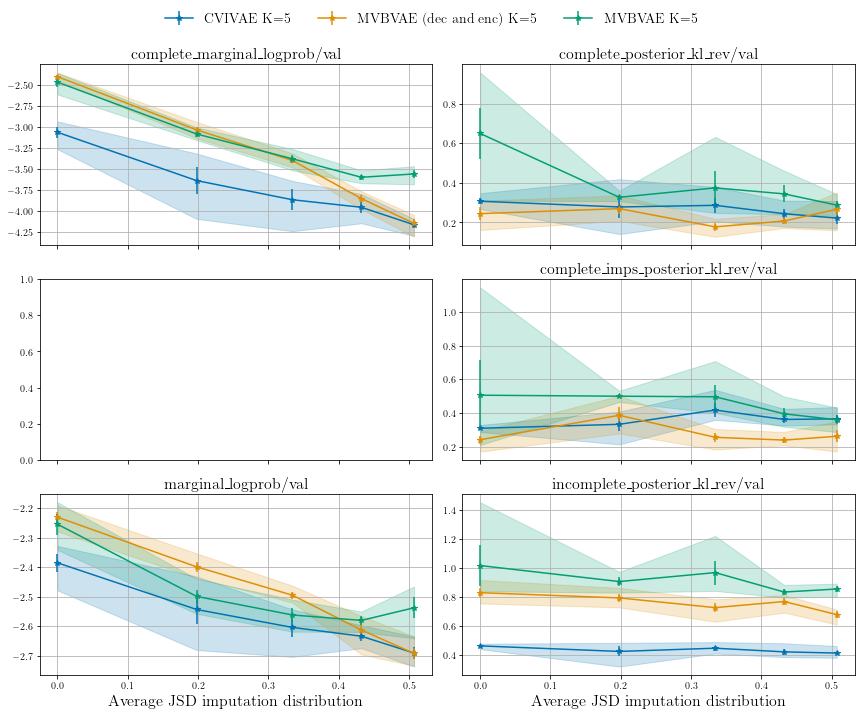

In [255]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metrics_to_use = [
    list(metrics.keys())[7],
    list(metrics.keys())[9],
    None,
    list(metrics.keys())[12],
    list(metrics.keys())[18],
    list(metrics.keys())[20],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

#### Train

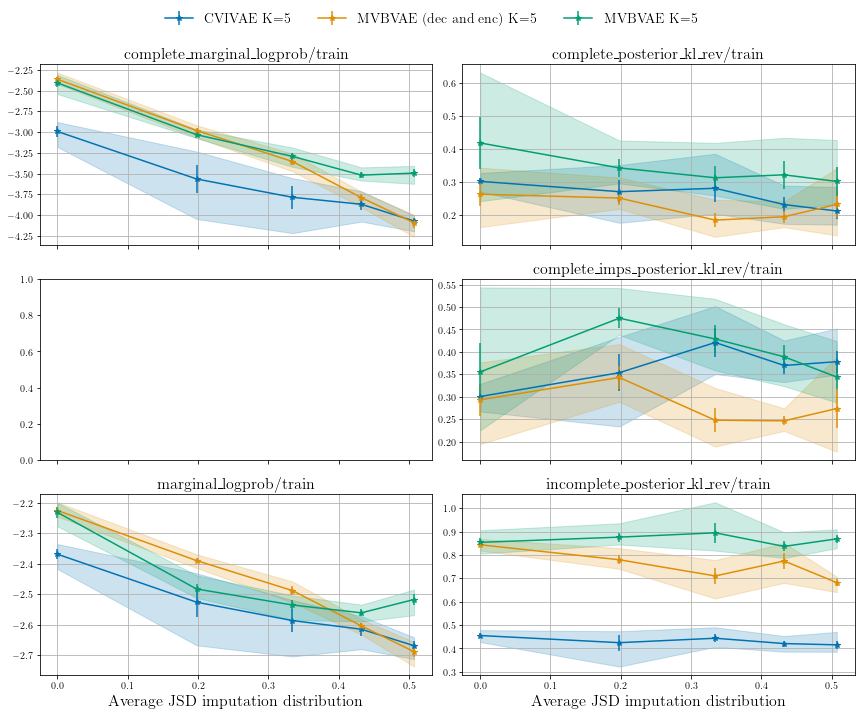

In [256]:
fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=False)
axes = axes.flatten()

colors = sns.color_palette(palette='colorblind', n_colors=len(model_stats))

oracle_jsd = []
for interp in model_stats[list(model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))


metrics_to_use = [
    list(metrics.keys())[0],
    list(metrics.keys())[2],
    None,
    list(metrics.keys())[5],
    list(metrics.keys())[14],
    list(metrics.keys())[16],
]    
    
for i, (model, stats_per_group) in enumerate(model_stats.items()):
    for j, m in enumerate(metrics_to_use):
        if m is None:
            continue
        groups = []
        means = []
        std_errs = []
        low_cis = []
        high_cis = []
        for group, stats in stats_per_group[m].items():
            groups.append(group)
            means.append(np.mean(stats))
            std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
            low_cis.append(np.quantile(stats, 0.05))
            high_cis.append(np.quantile(stats, 0.95))
        axes[j].errorbar(oracle_jsd, means, 
                         yerr=std_errs, 
                         label=model,
                         color=colors[i],
                         marker='*')
        axes[j].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

        axes[j].grid()
        axes[j].set_title(m, fontsize=16)
                                                                                 
# groups = [3,3,3,3,6]
# vline_x = -0.5
# for g in groups:
#     vline_x += g
#     axes[0].axvline(x=vline_x, color='k', linestyle=":")
#     axes[1].axvline(x=vline_x, color='k', linestyle=":")

axes[-2].set_xlabel('Average JSD imputation distribution', fontsize=16)
axes[-1].set_xlabel('Average JSD imputation distribution', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.95))

## Rejection sampler  of $p_{\theta}(x_m \mid x_o)$

In [3]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/sample_imps_from_vae_using_rejection_sampling/{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVIVAE K=5'
    },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
        'label_name': 'MVBVAE (dec and enc) K=5'
    },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
        'label_name': 'MVBVAE K=5'
    },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

# model_stats = defaultdict(lambda: defaultdict(list))
# for model in tqdm(models):
#     for seed in seeds:
#         log_dir = log_dir_template.format(model['name'], seed)

#         stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
#         for m in metrics:
#             model_stats[model['label_name']][m].append(np.nanmax(stats[m]))

model_stats = defaultdict(lambda: defaultdict(list))
model_stat_arg = defaultdict(lambda: defaultdict(list))
for model in tqdm(models):
    for seed in seeds:
        log_dir = log_dir_template.format(model['name'], seed)

        try:
            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    model_stats[model['label_name']][m].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][-1]
                    model_stats[model['label_name']][m].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m].append(arg)
        except FileNotFoundError:
            print(f'{log_dir} does not exist.')

#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

 67%|████████████████████████████████████████                    | 2/3 [00:25<00:12, 12.52s/it]

../logs/toy_mog2_large/sample_imps_from_vae_using_rejection_sampling/mvbvae_k5_stl_mlp/mis50/seed_m2022011844_d2022011844/lightning_logs/ does not exist.
../logs/toy_mog2_large/sample_imps_from_vae_using_rejection_sampling/mvb2vae_k5_stl_mlp/mis50/seed_m2022011822_d2022011822/lightning_logs/ does not exist.


100%|████████████████████████████████████████████████████████████| 3/3 [00:40<00:00, 13.58s/it]


/home/vaidas/Projects/vgiwae/vgiwae/utils/plotting.py:65: UserWarning: The palette list has more values (15) than needed (3), which may not be intended.
  sns.stripplot(


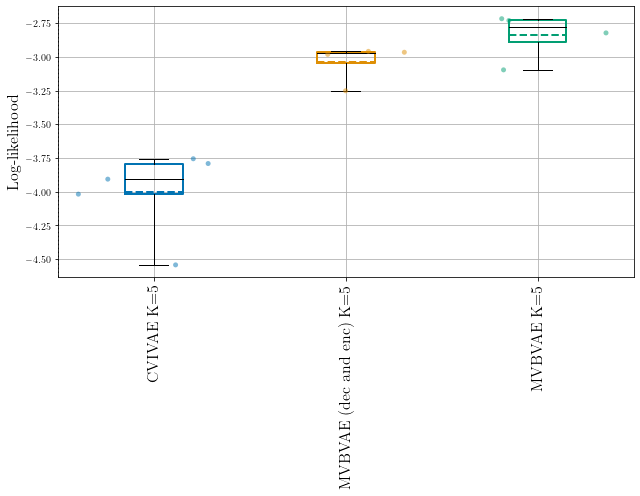

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(9,7), sharex=False, sharey=False)
# axes = axes.flatten()
axes = [axes]

colors = sns.color_palette(palette='colorblind', n_colors=10)
colors += ['r', 'g', 'b', 'c', 'm']

metric_box_data = defaultdict(list)
model_labels = []
for i, (model, stats) in enumerate(model_stats.items()):
    model_labels.append(model)

    metric0 = list(metrics.keys())[7]
    metric_box_data[metric0].append(stats[metric0])

plot_cust_boxplot(axes[0], metric_box_data[metric0], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
plot_custom_stripplot(axes[0], metric_box_data[metric0], model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.5})
    
axes[0].grid()
axes[0].set_ylabel('Log-likelihood', fontsize=16)


# axes[0].set_xticks(np.arange(0, len(metric_box_data[metric0])), labels=[])
axes[-1].set_xticks(np.arange(0, len(metric_box_data[metric0])), labels=model_labels, fontsize=16)
plt.setp(axes[-1].get_xticklabels(), rotation=90, ha='center')

groups = []
vline_x = -0.5
axes[0].axvline(x=vline_x, color='k', linestyle=":")
for g in groups:
    vline_x += g
    axes[0].axvline(x=vline_x, color='k', linestyle=":")

# axes[0].set_ylim(-2.7, None)
# axes[1].set_ylim(-2.7, None)
    
# handles, labels = axes[0].get_legend_handles_labels()
# axes[0].legend(handles, labels,
#           ncol=4, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', 
#           frameon=False, fontsize=12)

fig.tight_layout()

# fig.savefig('./figures/toymog2large_vae_complete_test_loglikelihood.pdf')

## Paper figures

### Load results

#### Rejection sampler

In [3]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/sample_imps_from_vae_using_rejection_sampling/{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVI-VAE'
    },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc)'
        'label_name': 'MVB-VAE'
    },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
#         'label_name': 'MVBVAE'
        'label_name': 'DeMissVAE'
    },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

rejection_sampler_model_stats = defaultdict(lambda: defaultdict(list))
model_stat_arg = defaultdict(lambda: defaultdict(list))
for model in tqdm(models):
    for seed in seeds:
        log_dir = log_dir_template.format(model['name'], seed)

        try:
            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    rejection_sampler_model_stats[model['label_name']][m].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][-1]
                    rejection_sampler_model_stats[model['label_name']][m].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m].append(arg)
        except FileNotFoundError:
            print(f'{log_dir} does not exist.')

#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|████████████████████████████████████████████████████████████| 3/3 [00:46<00:00, 15.36s/it]


#### Linear interpolate to independent marginal MoGs to independent marginal Gaussian

In [4]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'

seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_{{}}/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
oracle_interpolation_labels = ['050', '075', '090', '098', '100']
interp_target = 'indepmargmog_to_indepmarggauss'

imMoG_to_imG_oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp_target, interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            imMoG_to_imG_oracle_divs[interp_target + '_'+ interp][key].append(stats[key])
            
# oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_{{}}/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
oracle_interpolation_labels = ['000', '025', '050', '075', '100']
interp_target = 'indepmargmog'

for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp_target, interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            imMoG_to_imG_oracle_divs[interp_target + '_' + interp][key].append(stats[key])

In [5]:
data = 'toy_mog2_large'
group = 'mis50'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVI-VAE'
    },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc)'
        'label_name': 'MVB-VAE'
    },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
#         'label_name': 'MVBVAE'
        'label_name': 'DeMissVAE'
    },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_{{}}/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

oracle_interpolation_labels = ['050', '075', '090', '098', ]#'100']
interp_target = 'indepmargmog_to_indepmarggauss'
imMoG_to_imG_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(interp_target, model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    imMoG_to_imG_model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp_target + '_' + interp][-1]
                    imMoG_to_imG_model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp_target + '_' + interp].append(np.nanmax(stats[m]))

                
oracle_interpolation_labels = ['000', '025', '050', '075', '100']
interp_target = 'indepmargmog'

for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(interp_target, model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    imMoG_to_imG_model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp_target + '_' + interp][-1]
                    imMoG_to_imG_model_stats[model['label_name']][m][interp_target + '_' + interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp_target + '_' + interp].append(arg)
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp_target + '_' + interp].append(np.nanmax(stats[m]))

100%|███████████████████████████████████████████████████████████| 3/3 [06:18<00:00, 126.32s/it]


#### Linear interpolate to cond MoGs with equal component probabilities

In [6]:
# Load Oracle divs

data = 'toy_mog2_large'
group = 'mis50'
oracle_log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_equal_component_probabilities/interp{{}}/{group}/{{}}/lightning_logs/oracle_imputer_interpolated_distribution_divergences.npz'
seeds = ['seed_m20220118_d20220118',
#          'seed_m2022011811_d2022011811',
#          'seed_m2022011822_d2022011822',
#          'seed_m2022011833_d2022011833',
#          'seed_m2022011844_d2022011844'
        ]

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

cMoGeqp_oracle_divs = defaultdict(lambda: defaultdict(list))
for interp in oracle_interpolation_labels:
    for seed in seeds:
        log_dir = oracle_log_dir_template.format(interp, seed)
        stats = np.load(log_dir)
        for key in stats.keys():
            cMoGeqp_oracle_divs[interp][key].append(stats[key])

In [7]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/oracle_imp_with_interpolate_control_study_conditional_mog_with_equal_component_probabilities/{{}}_interp{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

models = [
    # CVIVAE
    {
        'name': 'cvivae_k5_stl_mlp',
        'label_name': 'CVI-VAE'
    },
    # MVB-VAE (both decoder and encoder)
    {
        'name': 'mvbvae_k5_stl_mlp',
#         'label_name': 'MVBVAE (dec and enc)'
        'label_name': 'MVB-VAE'
    },
    # MVB-VAE
    {
        'name': 'mvb2vae_k5_stl_mlp',
#         'label_name': 'MVBVAE'
        'label_name': 'DeMissVAE'
    },
]

metrics = {
    'complete_marginal_logprob/train': 'max',
    'complete_posterior_kl_fow/train': 'min',
    'complete_posterior_kl_rev/train': 'min',
    'complete_posterior_jsd/train': 'min',
    'complete_imps_posterior_kl_fow/train': 'min',
    'complete_imps_posterior_kl_rev/train': 'min',
    'complete_imps_posterior_jsd/train': 'min',
    
    'complete_marginal_logprob/val': 'max',
    'complete_posterior_kl_fow/val': 'min',
    'complete_posterior_kl_rev/val': 'min',
    'complete_posterior_jsd/val': 'min',
    'complete_imps_posterior_kl_fow/val': 'min',
    'complete_imps_posterior_kl_rev/val': 'min',
    'complete_imps_posterior_jsd/val': 'min',
    
    'marginal_logprob/train': 'max',
    'incomplete_posterior_kl_fow/train': 'min',
    'incomplete_posterior_kl_rev/train': 'min',
    'incomplete_posterior_jsd/train': 'min',
    
    'marginal_logprob/val': 'max',
    'incomplete_posterior_kl_fow/val': 'min',
    'incomplete_posterior_kl_rev/val': 'min',
    'incomplete_posterior_jsd/val': 'min',
}

dependent_metrics = {
    'complete_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_posterior_jsd/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_fow/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_kl_rev/train': 'complete_marginal_logprob/train',
    'complete_imps_posterior_jsd/train': 'complete_marginal_logprob/train',
    
    'complete_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_posterior_jsd/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_fow/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_kl_rev/val': 'complete_marginal_logprob/val',
    'complete_imps_posterior_jsd/val': 'complete_marginal_logprob/val',
    
    'incomplete_posterior_kl_fow/train': 'marginal_logprob/train',
    'incomplete_posterior_kl_rev/train': 'marginal_logprob/train',
    'incomplete_posterior_jsd/train': 'marginal_logprob/train',
    
    'incomplete_posterior_kl_fow/val': 'marginal_logprob/val',
    'incomplete_posterior_kl_rev/val': 'marginal_logprob/val',
    'incomplete_posterior_jsd/val': 'marginal_logprob/val',
}

oracle_interpolation_labels = ['000', '025', '050', '075', '100']

cMoGeqp_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
model_stat_arg = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in tqdm(models):
    for interp in oracle_interpolation_labels:
        for seed in seeds:
            log_dir = log_dir_template.format(model['name'], interp, seed)

            stats = load_stats(log_dir, stat_keys=['epoch', *(metrics.keys())])
            for m, op in metrics.items():
                if m not in dependent_metrics:
                    if op == 'max':
                        arg = np.nanargmax(stats[m])
                    elif op == 'min':
                        arg = np.nanargmin(stats[m])
                    cMoGeqp_model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                else:
                    dep_m = dependent_metrics[m]
                    arg = model_stat_arg[model['label_name']][dep_m][interp][-1]
                    cMoGeqp_model_stats[model['label_name']][m][interp].append(stats[m][arg])
                    model_stat_arg[model['label_name']][m][interp].append(arg)
                        
#             for m in metrics:
#                 model_stats[model['label_name']][m][interp].append(np.nanmax(stats[m]))

100%|███████████████████████████████████████████████████████████| 3/3 [06:19<00:00, 126.63s/it]


### Plot

#### Test log-likelihood

/home/vaidas/Projects/vgiwae/vgiwae/utils/plotting.py:65: UserWarning: The palette list has more values (15) than needed (3), which may not be intended.
  sns.stripplot(
/tmp/ipykernel_203541/3151156908.py:107: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(rect=(0, 0, 1, 0.88))


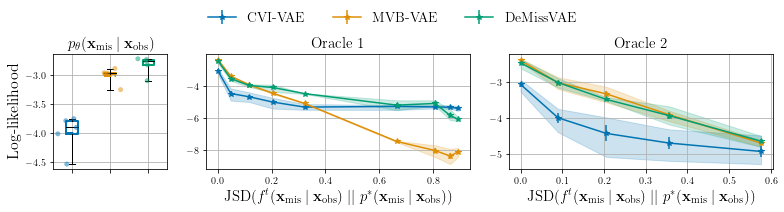

In [8]:
fig = plt.figure(layout="constrained", figsize=(11,3))
gs = mpl.gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1.3,3,3])

axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))

colors = sns.color_palette(palette='colorblind', n_colors=10)
colors += ['r', 'g', 'b', 'c', 'm']

# Figure 0

metric_box_data = defaultdict(list)
model_labels = []
for i, (model, stats) in enumerate(rejection_sampler_model_stats.items()):
    model_labels.append(model)

    metric0 = list(metrics.keys())[7]
    metric_box_data[metric0].append(stats[metric0])

plot_cust_boxplot(axes[0], metric_box_data[metric0], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
plot_custom_stripplot(axes[0], metric_box_data[metric0], model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.5})
axes[0].set_xticklabels([])

# Figure 1

oracle_jsd = []
for interp in imMoG_to_imG_model_stats[list(imMoG_to_imG_model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = imMoG_to_imG_oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metric = list(metrics.keys())[7]
    
for i, (model, stats_per_group) in enumerate(imMoG_to_imG_model_stats.items()):
    groups = []
    means = []
    std_errs = []
    low_cis = []
    high_cis = []
    for group, stats in stats_per_group[metric].items():
        groups.append(group)
        means.append(np.mean(stats))
        std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
        low_cis.append(np.quantile(stats, 0.05))
        high_cis.append(np.quantile(stats, 0.95))
    axes[1].errorbar(oracle_jsd, means, 
                     yerr=std_errs, 
                     label=model,
                     color=colors[i],
                     marker='*')
    axes[1].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

# Figure 2

oracle_jsd = []
for interp in cMoGeqp_model_stats[list(cMoGeqp_model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = cMoGeqp_oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metric = list(metrics.keys())[7]
    
for i, (model, stats_per_group) in enumerate(cMoGeqp_model_stats.items()):
    groups = []
    means = []
    std_errs = []
    low_cis = []
    high_cis = []
    for group, stats in stats_per_group[metric].items():
        groups.append(group)
        means.append(np.mean(stats))
        std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
        low_cis.append(np.quantile(stats, 0.05))
        high_cis.append(np.quantile(stats, 0.95))
    axes[2].errorbar(oracle_jsd, means, 
                     yerr=std_errs, 
                     label=model,
                     color=colors[i],
                     marker='*')
    axes[2].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)


axes[0].grid()
axes[0].set_ylabel('Log-likelihood', fontsize=16)
axes[0].set_title('$p_{\\theta}(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}})$', fontsize=15)
axes[1].grid()
axes[1].set_xlabel('$\\text{JSD}(f^t(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}) \mid\mid p^*(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}))$', fontsize=15)
axes[1].set_title('Oracle 1', fontsize=15)
axes[2].grid()
axes[2].set_xlabel('$\\text{JSD}(f^t(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}) \mid\mid p^*(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}))$', fontsize=15)
axes[2].set_title('Oracle 2', fontsize=15)

handles, labels = axes[1].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.88))

# fig.savefig('./figures/toymog2large_control_study_test_loglikelihood.pdf')

#### Train reverse KL 

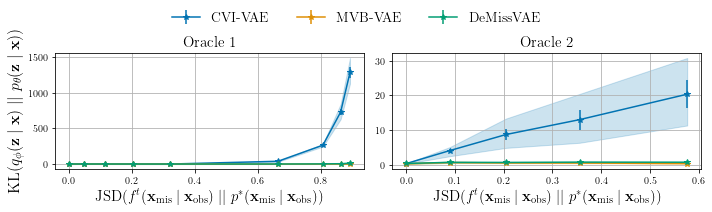

In [9]:
# fig = plt.figure(layout="constrained", figsize=(10,3))
# gs = mpl.gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1,3,3])

# axes = []
# axes.append(fig.add_subplot(gs[0, 0]))
# axes.append(fig.add_subplot(gs[0, 1]))
# axes.append(fig.add_subplot(gs[0, 2]))

fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=False, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=10)
colors += ['r', 'g', 'b', 'c', 'm']

# # Figure 0

# metric_box_data = defaultdict(list)
# model_labels = []
# for i, (model, stats) in enumerate(rejection_sampler_model_stats.items()):
#     model_labels.append(model)

#     metric0 = list(metrics.keys())[7]
#     metric_box_data[metric0].append(stats[metric0])

# plot_cust_boxplot(axes[0], metric_box_data[metric0], model_labels,
#                   colors=colors,
#                   meanline=True, showmeans=True,
#                   showfliers=False,)
# plot_custom_stripplot(axes[0], metric_box_data[metric0], model_labels, 
#                       colors=colors,
#                       no_trim=True, only_trim_up=False, 
#                       showmedians=False, 
#                       use_log_scale=False,
#                       stripplot_kw={'alpha': 0.5})
# axes[0].set_xticklabels([])

# Figure 1

oracle_jsd = []
for interp in imMoG_to_imG_model_stats[list(imMoG_to_imG_model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = imMoG_to_imG_oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metric = list(metrics.keys())[5]
    
for i, (model, stats_per_group) in enumerate(imMoG_to_imG_model_stats.items()):
    groups = []
    means = []
    std_errs = []
    low_cis = []
    high_cis = []
    for group, stats in stats_per_group[metric].items():
        groups.append(group)
        means.append(np.mean(stats))
        std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
        low_cis.append(np.quantile(stats, 0.05))
        high_cis.append(np.quantile(stats, 0.95))
    axes[0].errorbar(oracle_jsd, means, 
                     yerr=std_errs, 
                     label=model,
                     color=colors[i],
                     marker='*')
    axes[0].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)

# Figure 2

oracle_jsd = []
for interp in cMoGeqp_model_stats[list(cMoGeqp_model_stats.keys())[0]][list(metrics.keys())[0]].keys():
    stats = cMoGeqp_oracle_divs[interp]
    oracle_jsd.append(np.array(stats['jsd']).mean()/np.log(2))

metric = list(metrics.keys())[5]
    
for i, (model, stats_per_group) in enumerate(cMoGeqp_model_stats.items()):
    groups = []
    means = []
    std_errs = []
    low_cis = []
    high_cis = []
    for group, stats in stats_per_group[metric].items():
        groups.append(group)
        means.append(np.mean(stats))
        std_errs.append(np.std(stats, ddof=1)/np.sqrt(len(stats)))
        low_cis.append(np.quantile(stats, 0.05))
        high_cis.append(np.quantile(stats, 0.95))
    axes[1].errorbar(oracle_jsd, means, 
                     yerr=std_errs, 
                     label=model,
                     color=colors[i],
                     marker='*')
    axes[1].fill_between(oracle_jsd, low_cis, high_cis, color=colors[i], alpha=.2)


axes[0].grid()
axes[0].set_ylabel('$\\text{KL}(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \mid\mid p_{\\theta}(\mathbf{z} \mid \mathbf{x}))$', fontsize=16)
axes[0].set_xlabel('$\\text{JSD}(f^t(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}) \mid\mid p^*(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}))$', fontsize=15)
axes[0].set_title('Oracle 1', fontsize=15)
axes[1].grid()
axes[1].set_xlabel('$\\text{JSD}(f^t(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}) \mid\mid p^*(\mathbf{x}_{\\text{mis}} \mid \mathbf{x}_{\\text{obs}}))$', fontsize=15)
axes[1].set_title('Oracle 2', fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

# fig.tight_layout()
fig.tight_layout(rect=(0, 0, 1, 0.88))

# fig.savefig('./figures/toymog2large_control_study_train_kl_divs.pdf')

## Posterior visualisations 

In [5]:
large_datamodule = MissingDataModule(DATASET['toy_mog2_large'],
                         batch_size=200,
                         missingness=MISSINGNESS['uniform'], # TODO: load by subclass instead?
                         total_miss_train=0.5,         # TODO: load by subclass instead?
                         total_miss_val=0.5,         # TODO: load by subclass instead?
                         pre_imputation=PRE_IMPUTATION['oracle'],
                         pre_impute_val=True,
                         filter_fully_missing_train=True,
                         filter_fully_missing_val=True,
                         data_root="../data",
                         setup_seed=20220118)
large_datamodule.setup(stage='fit')
large_datamodule.setup(stage='test')


Train data size: 19366
Validation data size: 98
Test data size: 1000


In [7]:
vae_models = {
    'MVAE': {
        'model_class': 'VAEMargLogprob',
        'checkpoint': '../logs/toy_mog2_large/compare/vae_z25_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissVAE': {
        'model_class': 'VAEMargLogprob',
        'checkpoint': '../logs/toy_mog2_large/compare/reparametrisedmixture_vae_varnormeps_k25_z1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissSVAE': {
        'model_class': 'MultipleVAEMargLogprob',
        'checkpoint': '../logs/toy_mog2_large/compare/multiple_vae_k25_z1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
}
iwae_models = {
    'MIWAE': {
        'model_class': 'IWAEMargLogprob',
        'checkpoint': '../logs/toy_mog2_large/compare/iwae_i25_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissIWAE': {
        'model_class': 'IWAEMargLogprob',
        'checkpoint': '../logs/toy_mog2_large/compare/reparametrisedmixture_iwae_varnormeps_k25_i1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissSIWAE': {
        'model_class': 'MultipleIWAEMargLogprob',
        'checkpoint': '../logs/toy_mog2_large/compare/multiple_iwae_k25_i1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
}
demiss_models = {
    'DeMissVAE': {
        'model_class': 'MVBVAEMargLogprob',
        'checkpoint': '../logs/toy_mog2_large/compare/mvb2vae_lairdmisr0_k25_stl_mlp_store_imputations/mis50/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    }
}

Finding best model.
Using pre-trained model from: ../logs/toy_mog2_large/compare/vae_z25_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_1697838/checkpoints/epoch=499-step=151499.ckpt
Finding best model.
Using pre-trained model from: ../logs/toy_mog2_large/compare/reparametrisedmixture_vae_varnormeps_k25_z1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_1772192/checkpoints/epoch=499-step=151499.ckpt
Finding best model.
Using pre-trained model from: ../logs/toy_mog2_large/compare/multiple_vae_k25_z1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_1757690/checkpoints/epoch=499-step=151499.ckpt


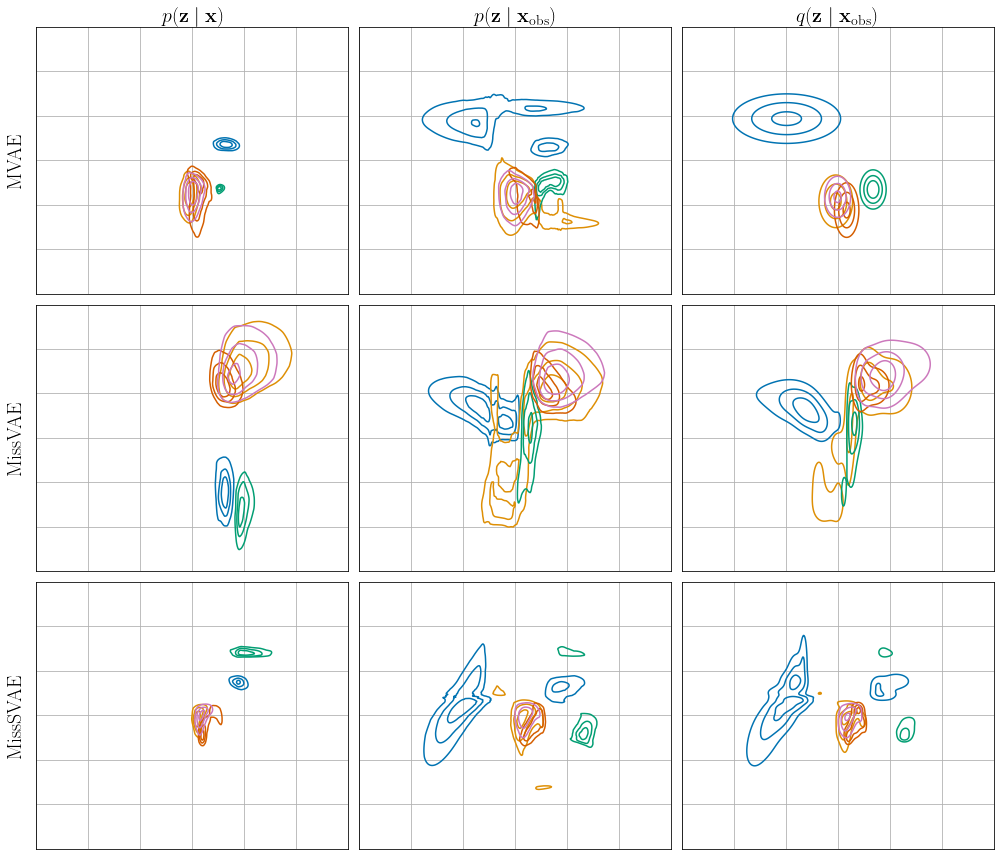

In [78]:
fig, axes = plt.subplots(len(vae_models), 3, sharex=True, sharey=True, figsize=(14, 12))

X_temp, M_temp = large_datamodule.train_data[20:25][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

grid_min, grid_max = -3, 3
colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

for i, (model_name, cfg) in enumerate(vae_models.items()):
    vae = load_vae_model(cfg['model_class'], cfg['checkpoint'], load_best_model=True)
    
    # Compute marginal and joint
    with torch.inference_mode():
        out = get_marginal_logprob_for_Zgrid(vae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                             compute_complete=True, return_joint=True, 
                                             marginal_eval_batchsize=1)

    # Complete data
    posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
    plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[i,0], colors=colors)
        
    # Incomplete data
    posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
    plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[i,1], colors=colors)
    
    # Incomplete variational
    with torch.inference_mode():
        variational_logprob = compute_incomplete_variational_posterior_grid_logprob(vae, X_temp, M_temp, Z)
    plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[i,2], colors=colors)

    axes[i, 0].set_ylabel(model_name, fontsize=20)
    
    for ax in axes[i]:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for tic in ax.xaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
        for tic in ax.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)

axes[0, 0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=20)
axes[0, 1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=20)
axes[0, 2].set_title('$q(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=20)
fig.tight_layout()

# fig.savefig('./figures/toymog2large_trained_model_posteriors_vae.pdf')

Finding best model.
Using pre-trained model from: ../logs/toy_mog2_large/compare/iwae_i25_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_1697828/checkpoints/epoch=499-step=151499.ckpt


100%|████████████████████████████████████████████████████████████| 5/5 [05:10<00:00, 62.08s/it]


Finding best model.
Using pre-trained model from: ../logs/toy_mog2_large/compare/reparametrisedmixture_iwae_varnormeps_k25_i1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_1772189/checkpoints/epoch=499-step=151499.ckpt


100%|████████████████████████████████████████████████████████████| 5/5 [04:51<00:00, 58.28s/it]


Finding best model.
Using pre-trained model from: ../logs/toy_mog2_large/compare/multiple_iwae_k25_i1_encm_stl_mlp/mis50/seed_m20220118_d20220118/lightning_logs/version_1757050/checkpoints/epoch=499-step=151499.ckpt


100%|████████████████████████████████████████████████████████████| 5/5 [05:01<00:00, 60.38s/it]


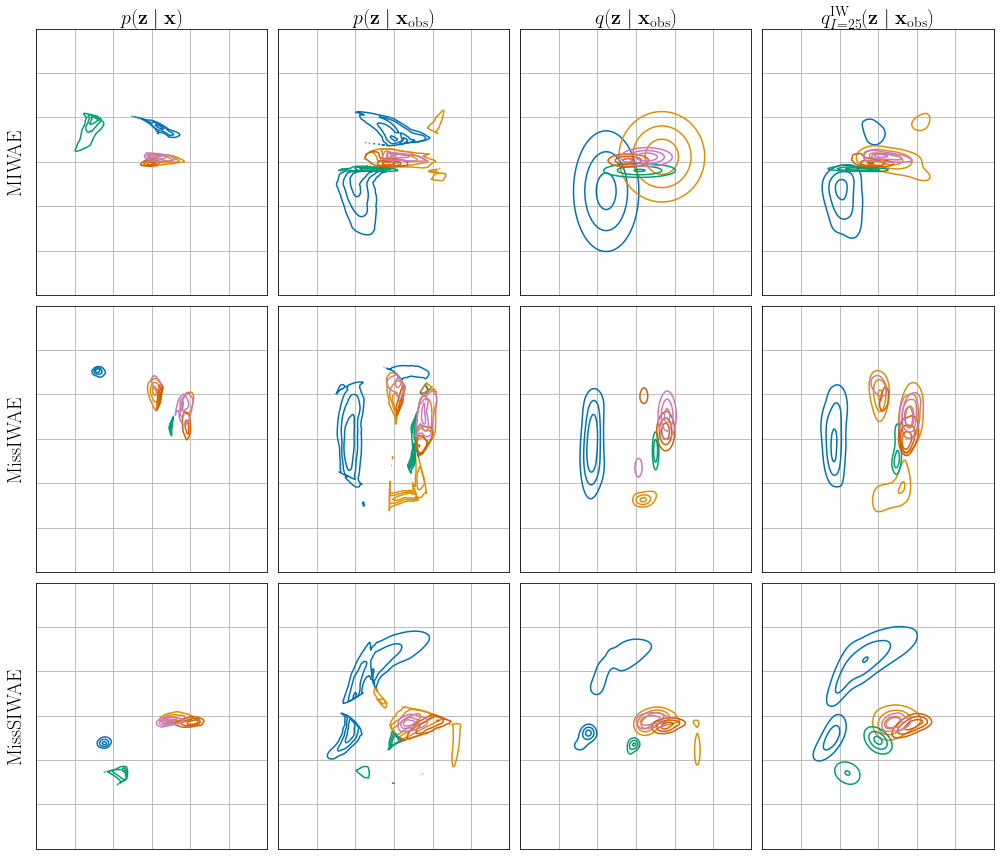

In [79]:
fig, axes = plt.subplots(len(iwae_models), 4, sharex=True, sharey=True, figsize=(14, 12))

X_temp, M_temp = large_datamodule.train_data[20:25][:2]
X_temp, M_temp = torch.tensor(X_temp), torch.tensor(M_temp)

grid_min, grid_max = -3, 3
colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

num_importance_samples = 25
num_indep_samples = 5000

for i, (model_name, cfg) in enumerate(iwae_models.items()):
    vae = load_vae_model(cfg['model_class'], cfg['checkpoint'], load_best_model=True)
    
    # Compute marginal and joint
    with torch.inference_mode():
        out = get_marginal_logprob_for_Zgrid(vae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                             compute_complete=True, return_joint=True, 
                                             marginal_eval_batchsize=1)

    # Complete data
    posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
    plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[i,0], colors=colors)
        
    # Incomplete data
    posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
    plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[i,1], colors=colors)
    
    # Incomplete variational
    with torch.inference_mode():
        variational_logprob = compute_incomplete_variational_posterior_grid_logprob(vae, X_temp, M_temp, Z)
    plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[i,2], colors=colors)

    # Inomplete importance-weighted
    with torch.inference_mode():
        variational_logprob = compute_iwae_posterior_grid_logprob_using_kde(vae, X_temp, M_temp, Z,
                                                                            num_importance_samples=num_importance_samples,
                                                                            num_indep_samples=num_indep_samples)
    plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[i,3], colors=colors)
    
    axes[i, 0].set_ylabel(model_name, fontsize=20)
    
    for ax in axes[i]:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for tic in ax.xaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
        for tic in ax.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)

axes[0, 0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=20)
axes[0, 1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=20)
axes[0, 2].set_title('$q(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=20)
axes[0, 3].set_title('$q^{\\text{IW}}_{I=25}(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=20)
fig.tight_layout()

# fig.savefig('./figures/toymog2large_trained_model_posteriors_iwae.pdf')

Finding best model.
Using pre-trained model from: ../logs/toy_mog2_large/compare/mvb2vae_lairdmisr0_k25_stl_mlp_store_imputations/mis50/seed_m20220118_d20220118/lightning_logs/version_1778407/checkpoints/epoch=499-step=151499.ckpt


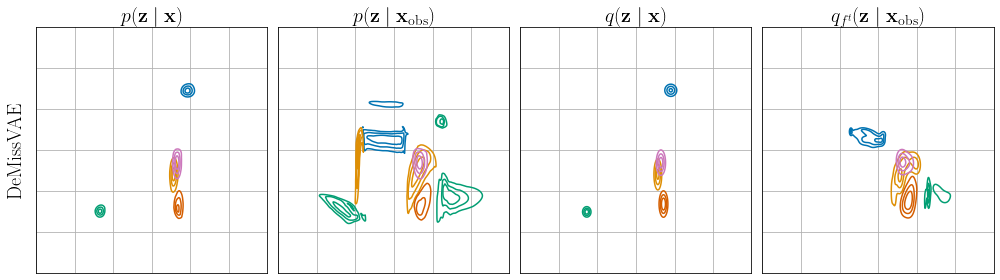

In [24]:
fig, axes = plt.subplots(len(demiss_models), 4, sharex=True, sharey=True, figsize=(14, 4))
axes = np.array([axes])

X_temp, M_temp, I_temp = large_datamodule.train_data[20:25][:3]
X_temp, M_temp, I_temp = torch.tensor(X_temp), torch.tensor(M_temp), torch.tensor(I_temp)

grid_min, grid_max = -3, 3
colors = sns.color_palette(palette='colorblind', n_colors=X_temp.shape[0])
Z, dz, (z0, z1) = create_Z(latent_dim=2, grid_min=grid_min, grid_max=grid_max, grid_steps=500)

for i, (model_name, cfg) in enumerate(demiss_models.items()):
    vae = load_vae_model(cfg['model_class'], cfg['checkpoint'], load_best_model=True)
    
    # Load imputations from last iteration of training
    imp_path = os.path.join(cfg['checkpoint'].split('checkpoints')[0], 'imputations', 'train_imputations_last.npz')
    imp_distr = load_impdistr(imp_path)
    X_imp, M_imp = imp_distr.get_imputed_datapoints((X_temp, M_temp, I_temp))[:2]
    
    # Compute marginal and joint
    with torch.inference_mode():
        out = get_marginal_logprob_for_Zgrid(vae, batch=(X_temp, M_temp), Z=Z, dz=dz, 
                                             compute_complete=True, return_joint=True, 
                                             marginal_eval_batchsize=1)

    # Complete data
    posterior_logprob = out['complete_joint_logprob_pxz'] - out['complete_marginal_logprob_px']
    plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[i,0], colors=colors)
        
    # Incomplete data
    posterior_logprob = out['joint_logprob_pxoz'] - out['marginal_logprob_pxo']
    plot_2d_vae_post(posterior_logprob, z0, z1, ax=axes[i,1], colors=colors)
    
    # Complete variational
    with torch.inference_mode():
        variational_logprob = compute_complete_variational_posterior_grid_logprob(vae, X_temp, Z)
    plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[i,2], colors=colors)
    
    # Mixture variational (incomplete)
    with torch.inference_mode():
        variational_logprob = compute_variational_imputation_mixture(vae, X_imp, Z)
    plot_2d_vae_post(variational_logprob, z0, z1, ax=axes[i,3], colors=colors)

    axes[i, 0].set_ylabel(model_name, fontsize=20)
    
    for ax in axes[i]:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for tic in ax.xaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
        for tic in ax.yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)

axes[0, 0].set_title('$p(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=20)
axes[0, 1].set_title('$p(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=20)
axes[0, 2].set_title('$q(\\mathbf{z} \\mid \\mathbf{x})$', fontsize=20)
axes[0, 3].set_title('$q_{f^t}(\\mathbf{z} \\mid \\mathbf{x}_{\\text{obs}})$', fontsize=20)
fig.tight_layout()

# fig.savefig('./figures/toymog2large_trained_model_posteriors_demiss.pdf')

## Gradient variance and signal-to-noise

In [82]:
data = 'toy_mog2_large'
group = 'mis50'
log_dir_template = f'../logs/{data}/gradvar/{{}}/{group}/{{}}/lightning_logs/'

seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

gradvar_models = [
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_varnormeps_k5_z1_encm_stl_mlp',
        'label_name': 'MissVAE K=5 Z=5'
    },
#     {
#         'name': 'reparametrisedmixture_vae_varnormeps_k15_z1_encm_stl_mlp',
#         'label_name': 'MissVAE K=15 Z=15'
#     },
#     {
#         'name': 'reparametrisedmixture_vae_varnormeps_k25_z1_encm_stl_mlp',
#         'label_name': 'MissVAE K=25 Z=25'
#     },
    # MultipleVAE
    {
        'name': 'multiple_vae_k5_z1_encm_stl_mlp',
        'label_name': 'MissSVAE K=5 Z=1'
    },
#     {
#         'name': 'multiple_vae_k15_z1_encm_stl_mlp',
#         'label_name': 'MissSVAE K=15 Z=1'
#     },
#     {
#         'name': 'multiple_vae_k25_z1_encm_stl_mlp',
#         'label_name': 'MissSVAE K=25 Z=1'
#     },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_varnormeps_k5_i1_encm_stl_mlp',
        'label_name': 'MissIWAE K=5 I=5'
    },
#     {
#         'name': 'reparametrisedmixture_iwae_varnormeps_k15_i1_encm_stl_mlp',
#         'label_name': 'MissIWAE K=15 I=15'
#     },
#     {
#         'name': 'reparametrisedmixture_iwae_varnormeps_k25_i1_encm_stl_mlp',
#         'label_name': 'MissIWAE K=25 I=25'
#     },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_k5_i1_encm_stl_mlp',
        'label_name': 'MissSIWAE K=5 I=1'
    },
#     {
#         'name': 'multiple_iwae_k15_i1_encm_stl_mlp',
#         'label_name': 'MissSIWAE K=15 I=1'
#     },
#     {
#         'name': 'multiple_iwae_k25_i1_encm_stl_mlp',
#         'label_name': 'MissSIWAE K=25 I=1'
#     },
]


metrics = ['encoder_grad_snr/train',
           'encoder_grad_var/train',
           'generator_grad_snr/train',
           'generator_grad_var/train',]

gradvar_model_stats = defaultdict(lambda: defaultdict(list))
for model in tqdm(gradvar_models):
    for seed in seeds:
        log_dir = log_dir_template.format(model['name'], seed)

        stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
        for m in metrics:
            gradvar_model_stats[model['label_name']][m].append(stats[m])


100%|████████████████████████████████████████████████████████████| 4/4 [02:40<00:00, 40.13s/it]


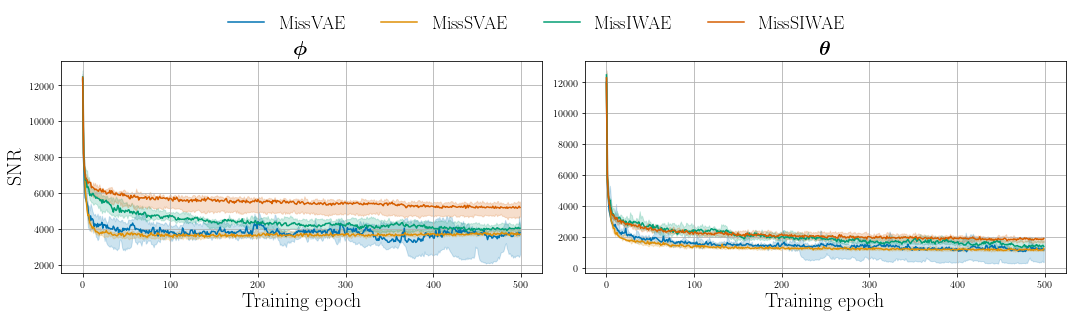

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(15,4.5), sharex=False, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=len(gradvar_models))
colors += ['r', 'g', 'b', 'c', 'm']


for m, model in enumerate(gradvar_models):
    model_label = model['label_name']
    model_label = re.split('Z=|K=|I=', model_label)[0]
    
    metric = 'encoder_grad_snr/train'
    stat = gradvar_model_stats[model['label_name']][metric]
    stat = np.array(stat)

    median = np.nanmedian(stat, axis=0)
    low_ci = np.nanquantile(stat, 0.05, axis=0)
    high_ci = np.nanquantile(stat, 0.95, axis=0)
    axes[0].plot(np.arange(len(median)), median, color=colors[m], label=model_label)
    axes[0].fill_between(np.arange(len(median)), low_ci, high_ci, color=colors[m], alpha=.2)
    axes[0].set_ylabel('SNR', fontsize=20)
    
    metric = 'generator_grad_snr/train'
    stat = gradvar_model_stats[model['label_name']][metric]
    stat = np.array(stat)

    median = np.nanmedian(stat, axis=0)
    low_ci = np.nanquantile(stat, 0.05, axis=0)
    high_ci = np.nanquantile(stat, 0.95, axis=0)
    axes[1].plot(np.arange(len(median)), median, color=colors[m], label=model_label)
    axes[1].fill_between(np.arange(len(median)), low_ci, high_ci, color=colors[m], alpha=.2)

axes[0].grid()
axes[1].grid()
    
axes[0].set_title('$\\bm{\\phi}$', fontsize=20)
axes[1].set_title('$\\bm{\\theta}$', fontsize=20)
axes[0].set_xlabel('Training epoch', fontsize=20)
axes[1].set_xlabel('Training epoch', fontsize=20)

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=4, loc='upper center',
              frameon=False, fontsize=18)

fig.tight_layout(rect=(0, 0, 1, 0.9))

# fig.savefig('./figures/toymog2large_gradvar.pdf')